In [2]:
print("=" * 70)
print("STEP 1: CONNECTING TO GOOGLE DRIVE")
print("=" * 70)

from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive connected successfully!")

STEP 1: CONNECTING TO GOOGLE DRIVE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive connected successfully!


In [3]:
print("\n📦 Installing required libraries...")
!pip install -q pillow opencv-python matplotlib scikit-learn pandas

# Import libraries
import os
import zipfile
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter
import cv2
import json

print("✅ All libraries loaded!")


📦 Installing required libraries...
✅ All libraries loaded!


In [7]:
print("\n" + "=" * 70)
print("STEP 2: UNZIPPING YOUR DATASET")
print("=" * 70)

# Set your paths (CHANGE THESE IF YOUR FOLDER NAMES ARE DIFFERENT!)
DRIVE_PATH = '/content/drive/MyDrive/Dataset/train.zip'  # Your zip file location
EXTRACT_PATH = '/content/fruit_dataset'  # Where to extract
TRAIN_PATH = os.path.join(EXTRACT_PATH, 'train')  # Final training folder

# Check if zip file exists
if not os.path.exists(DRIVE_PATH):
    print("❌ ERROR: Zip file not found!")
    print(f"Looking for: {DRIVE_PATH}")
    print("\n🔍 Let me check what's in your Drive...")
    print("Files in MyDrive:")
    for item in os.listdir('/content/drive/MyDrive'):
        print(f"  - {item}")
    print("\n💡 TIP: Update DRIVE_PATH variable with correct folder name!")
else:
    print(f"✅ Found zip file: {DRIVE_PATH}")

    # Unzip the dataset
    print("\n📂 Unzipping... (this may take 1-2 minutes)")
    with zipfile.ZipFile(DRIVE_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

    print(f"✅ Dataset extracted to: {EXTRACT_PATH}")


STEP 2: UNZIPPING YOUR DATASET
✅ Found zip file: /content/drive/MyDrive/Dataset/train.zip

📂 Unzipping... (this may take 1-2 minutes)
✅ Dataset extracted to: /content/fruit_dataset


In [9]:
print("\n" + "=" * 70)
print("STEP 3: ORGANIZING AND EXPLORING YOUR DATA")
print("=" * 70)

# Get all fruit/vegetable categories (folders)
categories = sorted([d for d in os.listdir(TRAIN_PATH)
                    if os.path.isdir(os.path.join(TRAIN_PATH, d))])

print(f"\n📊 DATASET SUMMARY")
print("-" * 70)
print(f"Total Categories (Fruit/Veg Types): {len(categories)}")
print(f"Location: {TRAIN_PATH}")

# Count images in each category
category_stats = {}
for cat in categories:
    cat_path = os.path.join(TRAIN_PATH, cat)
    images = [f for f in os.listdir(cat_path)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    category_stats[cat] = len(images)

# Display all categories with image counts
print("\n📁 ALL CATEGORIES:")
print("-" * 70)
for i, (cat, count) in enumerate(category_stats.items(), 1):
    print(f"{i:3d}. {cat:25s} → {count:4d} images")

total_images = sum(category_stats.values())
print("-" * 70)
print(f"TOTAL IMAGES: {total_images}")
print("=" * 70)

# Find categories with too few or too many images
min_images = min(category_stats.values())
max_images = max(category_stats.values())
avg_images = total_images / len(categories)

print(f"\n📈 DISTRIBUTION ANALYSIS:")
print(f"   Minimum images per category: {min_images}")
print(f"   Maximum images per category: {max_images}")
print(f"   Average images per category: {avg_images:.1f}")

# Warn about imbalanced categories
imbalanced = [(cat, count) for cat, count in category_stats.items()
              if count < avg_images * 0.5 or count > avg_images * 2]
if imbalanced:
    print("\n⚠️  IMBALANCED CATEGORIES (may need augmentation):")
    for cat, count in imbalanced:
        print(f"   - {cat}: {count} images")


STEP 3: ORGANIZING AND EXPLORING YOUR DATA

📊 DATASET SUMMARY
----------------------------------------------------------------------
Total Categories (Fruit/Veg Types): 36
Location: /content/fruit_dataset/train

📁 ALL CATEGORIES:
----------------------------------------------------------------------
  1. apple                     →   68 images
  2. banana                    →   75 images
  3. beetroot                  →   88 images
  4. bell pepper               →   90 images
  5. cabbage                   →   92 images
  6. capsicum                  →   89 images
  7. carrot                    →   82 images
  8. cauliflower               →   79 images
  9. chilli pepper             →   87 images
 10. corn                      →   87 images
 11. cucumber                  →   94 images
 12. eggplant                  →   84 images
 13. garlic                    →   92 images
 14. ginger                    →   68 images
 15. grapes                    →  100 images
 16. jalepeno          

In [10]:
print("\n" + "=" * 70)
print("STEP 4: CHECKING IMAGE QUALITY")
print("=" * 70)

def check_image_quality(categories, sample_per_category=10):
    """Check for corrupted, duplicate, or poor quality images"""

    issues = {
        'corrupted': [],
        'too_small': [],
        'grayscale': [],
        'different_formats': Counter()
    }

    total_checked = 0
    widths = []
    heights = []

    print("\n🔍 Analyzing image quality...")

    for cat in categories:
        cat_path = os.path.join(TRAIN_PATH, cat)
        images = [f for f in os.listdir(cat_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Check a sample from each category
        sample = images[:min(sample_per_category, len(images))]

        for img_name in sample:
            img_path = os.path.join(cat_path, img_name)
            total_checked += 1

            try:
                # Try opening image
                img = Image.open(img_path)
                width, height = img.size
                widths.append(width)
                heights.append(height)

                # Check file format
                issues['different_formats'][img.format] += 1

                # Check if too small
                if width < 50 or height < 50:
                    issues['too_small'].append(f"{cat}/{img_name}")

                # Check if grayscale
                if img.mode not in ['RGB', 'RGBA']:
                    issues['grayscale'].append(f"{cat}/{img_name}")

                img.close()

            except Exception as e:
                issues['corrupted'].append(f"{cat}/{img_name}")

    # Print results
    print(f"\n✅ Checked {total_checked} sample images")
    print("\n📊 IMAGE QUALITY REPORT:")
    print("-" * 70)

    # File formats
    print("\n📄 File Formats Found:")
    for fmt, count in issues['different_formats'].items():
        print(f"   - {fmt}: {count} images")

    # Corrupted images
    if issues['corrupted']:
        print(f"\n❌ CORRUPTED IMAGES ({len(issues['corrupted'])}):")
        for img in issues['corrupted'][:5]:
            print(f"   - {img}")
        if len(issues['corrupted']) > 5:
            print(f"   ... and {len(issues['corrupted']) - 5} more")
    else:
        print("\n✅ No corrupted images found!")

    # Too small images
    if issues['too_small']:
        print(f"\n⚠️  TOO SMALL IMAGES ({len(issues['too_small'])}):")
        for img in issues['too_small'][:5]:
            print(f"   - {img}")
        if len(issues['too_small']) > 5:
            print(f"   ... and {len(issues['too_small']) - 5} more")
    else:
        print("\n✅ All images have good dimensions!")

    # Grayscale images
    if issues['grayscale']:
        print(f"\n⚠️  GRAYSCALE IMAGES ({len(issues['grayscale'])}):")
        for img in issues['grayscale'][:5]:
            print(f"   - {img}")
    else:
        print("\n✅ All images are in color (RGB)!")

    # Dimension statistics
    if widths:
        print(f"\n📐 IMAGE DIMENSIONS:")
        print(f"   Width  → Min: {min(widths):4d}px, Max: {max(widths):4d}px, Avg: {np.mean(widths):.0f}px")
        print(f"   Height → Min: {min(heights):4d}px, Max: {max(heights):4d}px, Avg: {np.mean(heights):.0f}px")

    return issues, widths, heights

# Run quality check
issues, widths, heights = check_image_quality(categories)


STEP 4: CHECKING IMAGE QUALITY

🔍 Analyzing image quality...

✅ Checked 360 sample images

📊 IMAGE QUALITY REPORT:
----------------------------------------------------------------------

📄 File Formats Found:
   - JPEG: 344 images
   - PNG: 15 images
   - MPO: 1 images

✅ No corrupted images found!

✅ All images have good dimensions!

⚠️  GRAYSCALE IMAGES (2):
   - raddish/Image_38.png
   - tomato/Image_31.png

📐 IMAGE DIMENSIONS:
   Width  → Min:  172px, Max: 6000px, Avg: 1368px
   Height → Min:  189px, Max: 6000px, Avg: 1135px


In [11]:
print("\n" + "=" * 70)
print("STEP 5: VISUALIZING SAMPLE IMAGES")
print("=" * 70)

def show_sample_images(categories, num_categories=6, images_per_category=4):
    """Display sample images from random categories"""
    import random

    selected_categories = random.sample(categories,
                                       min(num_categories, len(categories)))

    fig, axes = plt.subplots(num_categories, images_per_category,
                            figsize=(16, 3*num_categories))
    fig.suptitle('📸 Sample Images from Your Dataset',
                 fontsize=18, fontweight='bold', y=0.995)

    for i, category in enumerate(selected_categories):
        cat_path = os.path.join(TRAIN_PATH, category)
        images = [f for f in os.listdir(cat_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        selected_images = random.sample(images,
                                       min(images_per_category, len(images)))

        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(cat_path, img_name)

            try:
                img = Image.open(img_path)

                ax = axes[i, j] if num_categories > 1 else axes[j]
                ax.imshow(img)
                ax.axis('off')

                # Add category name to first image
                if j == 0:
                    ax.text(0, -10, category.upper(),
                           fontsize=11, fontweight='bold',
                           bbox=dict(boxstyle='round',
                                   facecolor='yellow', alpha=0.7))

                # Add image size info
                ax.text(5, img.height - 5, f"{img.width}×{img.height}",
                       fontsize=8, color='white',
                       bbox=dict(boxstyle='round',
                               facecolor='black', alpha=0.6))

                img.close()
            except:
                ax.text(0.5, 0.5, 'Image Error',
                       ha='center', va='center')
                ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\n🖼️  Displaying sample images...")
show_sample_images(categories)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
print("\n" + "=" * 70)
print("STEP 6: CREATING ORGANIZED FOLDER STRUCTURE")
print("=" * 70)

# Create organized structure
ORGANIZED_PATH = os.path.join(EXTRACT_PATH, 'organized_data')
os.makedirs(ORGANIZED_PATH, exist_ok=True)

print(f"\n📁 Creating organized structure at: {ORGANIZED_PATH}")
print("   This will help us split train/validation sets later!")

# Just verify the structure is good
print("\n✅ Your data structure looks good!")
print("\n📂 Current Structure:")
print(f"   {TRAIN_PATH}/")
for cat in categories[:5]:
    print(f"      ├── {cat}/")
    print(f"      │      ├── image1.jpg")
    print(f"      │      ├── image2.jpg")
    print(f"      │      └── ...")
if len(categories) > 5:
    print(f"      └── ... and {len(categories) - 5} more categories")


STEP 6: CREATING ORGANIZED FOLDER STRUCTURE

📁 Creating organized structure at: /content/fruit_dataset/organized_data
   This will help us split train/validation sets later!

✅ Your data structure looks good!

📂 Current Structure:
   /content/fruit_dataset/train/
      ├── apple/
      │      ├── image1.jpg
      │      ├── image2.jpg
      │      └── ...
      ├── banana/
      │      ├── image1.jpg
      │      ├── image2.jpg
      │      └── ...
      ├── beetroot/
      │      ├── image1.jpg
      │      ├── image2.jpg
      │      └── ...
      ├── bell pepper/
      │      ├── image1.jpg
      │      ├── image2.jpg
      │      └── ...
      ├── cabbage/
      │      ├── image1.jpg
      │      ├── image2.jpg
      │      └── ...
      └── ... and 31 more categories


In [13]:
print("\n" + "=" * 70)
print("STEP 7: SAVING DATASET INFORMATION")
print("=" * 70)

# Create label mapping
label_to_idx = {cat: idx for idx, cat in enumerate(categories)}
idx_to_label = {idx: cat for cat, idx in label_to_idx.items()}

# Save metadata
metadata = {
    'total_categories': len(categories),
    'total_images': total_images,
    'categories': categories,
    'label_mapping': label_to_idx,
    'category_counts': category_stats,
    'image_dimensions': {
        'width_min': int(min(widths)) if widths else 0,
        'width_max': int(max(widths)) if widths else 0,
        'width_avg': float(np.mean(widths)) if widths else 0,
        'height_min': int(min(heights)) if heights else 0,
        'height_max': int(max(heights)) if heights else 0,
        'height_avg': float(np.mean(heights)) if heights else 0
    }
}

metadata_path = os.path.join(EXTRACT_PATH, 'dataset_info.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Dataset information saved to: {metadata_path}")


STEP 7: SAVING DATASET INFORMATION
✅ Dataset information saved to: /content/fruit_dataset/dataset_info.json


In [14]:
print("\n" + "=" * 70)
print("🎉 DATA PREPARATION COMPLETE!")
print("=" * 70)

print(f"""
✅ WHAT WE DID:
   1. Connected to Google Drive
   2. Unzipped your dataset ({total_images} images)
   3. Found {len(categories)} fruit/vegetable categories
   4. Checked image quality (found {len(issues['corrupted'])} issues)
   5. Visualized sample images
   6. Organized folder structure
   7. Saved dataset information

📊 YOUR DATASET:
   • Total Images: {total_images}
   • Total Categories: {len(categories)}
   • Location: {TRAIN_PATH}
   • Info File: {metadata_path}

🎯 NEXT STEPS:
   1. Data Augmentation (create more training images)
   2. Train/Test Split (80/20)
   3. Build CNN Model
   4. Train the model

💡 Ready to move to the next step? Just let me know!
""")

print("=" * 70)


🎉 DATA PREPARATION COMPLETE!

✅ WHAT WE DID:
   1. Connected to Google Drive
   2. Unzipped your dataset (3115 images)
   3. Found 36 fruit/vegetable categories
   4. Checked image quality (found 0 issues)
   5. Visualized sample images
   6. Organized folder structure
   7. Saved dataset information

📊 YOUR DATASET:
   • Total Images: 3115
   • Total Categories: 36
   • Location: /content/fruit_dataset/train
   • Info File: /content/fruit_dataset/dataset_info.json

🎯 NEXT STEPS:
   1. Data Augmentation (create more training images)
   2. Train/Test Split (80/20)
   3. Build CNN Model
   4. Train the model

💡 Ready to move to the next step? Just let me know!



In [15]:
print("=" * 70)
print("🎨 DATA AUGMENTATION - CREATING MORE TRAINING IMAGES")
print("=" * 70)

# Install augmentation library
print("\n📦 Installing image augmentation library...")
!pip install -q albumentations

import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from pathlib import Path
import shutil
from tqdm import tqdm
import random
import json

print("✅ Libraries loaded successfully!")

🎨 DATA AUGMENTATION - CREATING MORE TRAINING IMAGES

📦 Installing image augmentation library...
✅ Libraries loaded successfully!


In [17]:
print("\n" + "=" * 70)
print("📁 SETTING UP FOLDERS")
print("=" * 70)

# Original data path
TRAIN_PATH = '/content/fruit_dataset/train'

# New augmented data path
AUGMENTED_PATH = '/content/fruit_dataset/augmented_data'
os.makedirs(AUGMENTED_PATH, exist_ok=True)

print(f"✅ Original data: {TRAIN_PATH}")
print(f"✅ Augmented data will be saved to: {AUGMENTED_PATH}")

# Get all categories
categories = sorted([d for d in os.listdir(TRAIN_PATH)
                    if os.path.isdir(os.path.join(TRAIN_PATH, d))])
print(f"✅ Found {len(categories)} categories")


📁 SETTING UP FOLDERS
✅ Original data: /content/fruit_dataset/train
✅ Augmented data will be saved to: /content/fruit_dataset/augmented_data
✅ Found 36 categories


In [18]:
print("\n" + "=" * 70)
print("🎨 DEFINING AUGMENTATION TECHNIQUES")
print("=" * 70)

print("""
We'll apply these transformations to create new images:

1. 🔄 HORIZONTAL FLIP - Mirror the image left/right
2. 🔃 ROTATION - Rotate slightly (-20° to +20°)
3. ☀️ BRIGHTNESS - Make brighter or darker
4. 🌈 CONTRAST - Adjust image contrast
5. 🔍 ZOOM - Slight zoom in/out
6. 📐 SHIFT - Move image slightly up/down/left/right
7. 🎨 HUE/SATURATION - Change color tones slightly
""")

# Create augmentation pipeline
augmentation_pipeline = A.Compose([
    # Geometric transformations
    A.HorizontalFlip(p=0.5),  # 50% chance to flip
    A.Rotate(limit=20, p=0.5),  # Rotate between -20 to +20 degrees
    A.ShiftScaleRotate(
        shift_limit=0.1,  # Shift by 10%
        scale_limit=0.1,  # Zoom by 10%
        rotate_limit=0,
        p=0.5
    ),

    # Color transformations
    A.RandomBrightnessContrast(
        brightness_limit=0.2,  # Brightness adjustment
        contrast_limit=0.2,    # Contrast adjustment
        p=0.5
    ),
    A.HueSaturationValue(
        hue_shift_limit=10,     # Slight color shift
        sat_shift_limit=20,     # Saturation adjustment
        val_shift_limit=10,     # Value adjustment
        p=0.3
    ),

    # Quality transformations
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),  # Slight blur
])

print("✅ Augmentation pipeline created!")


🎨 DEFINING AUGMENTATION TECHNIQUES

We'll apply these transformations to create new images:

1. 🔄 HORIZONTAL FLIP - Mirror the image left/right
2. 🔃 ROTATION - Rotate slightly (-20° to +20°)
3. ☀️ BRIGHTNESS - Make brighter or darker
4. 🌈 CONTRAST - Adjust image contrast
5. 🔍 ZOOM - Slight zoom in/out
6. 📐 SHIFT - Move image slightly up/down/left/right
7. 🎨 HUE/SATURATION - Change color tones slightly

✅ Augmentation pipeline created!


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



👀 SEEING AUGMENTATION IN ACTION

📸 Showing augmentation examples using: cucumber/Image_100.jpg


/tmp/ipython-input-1641719595.py:42: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


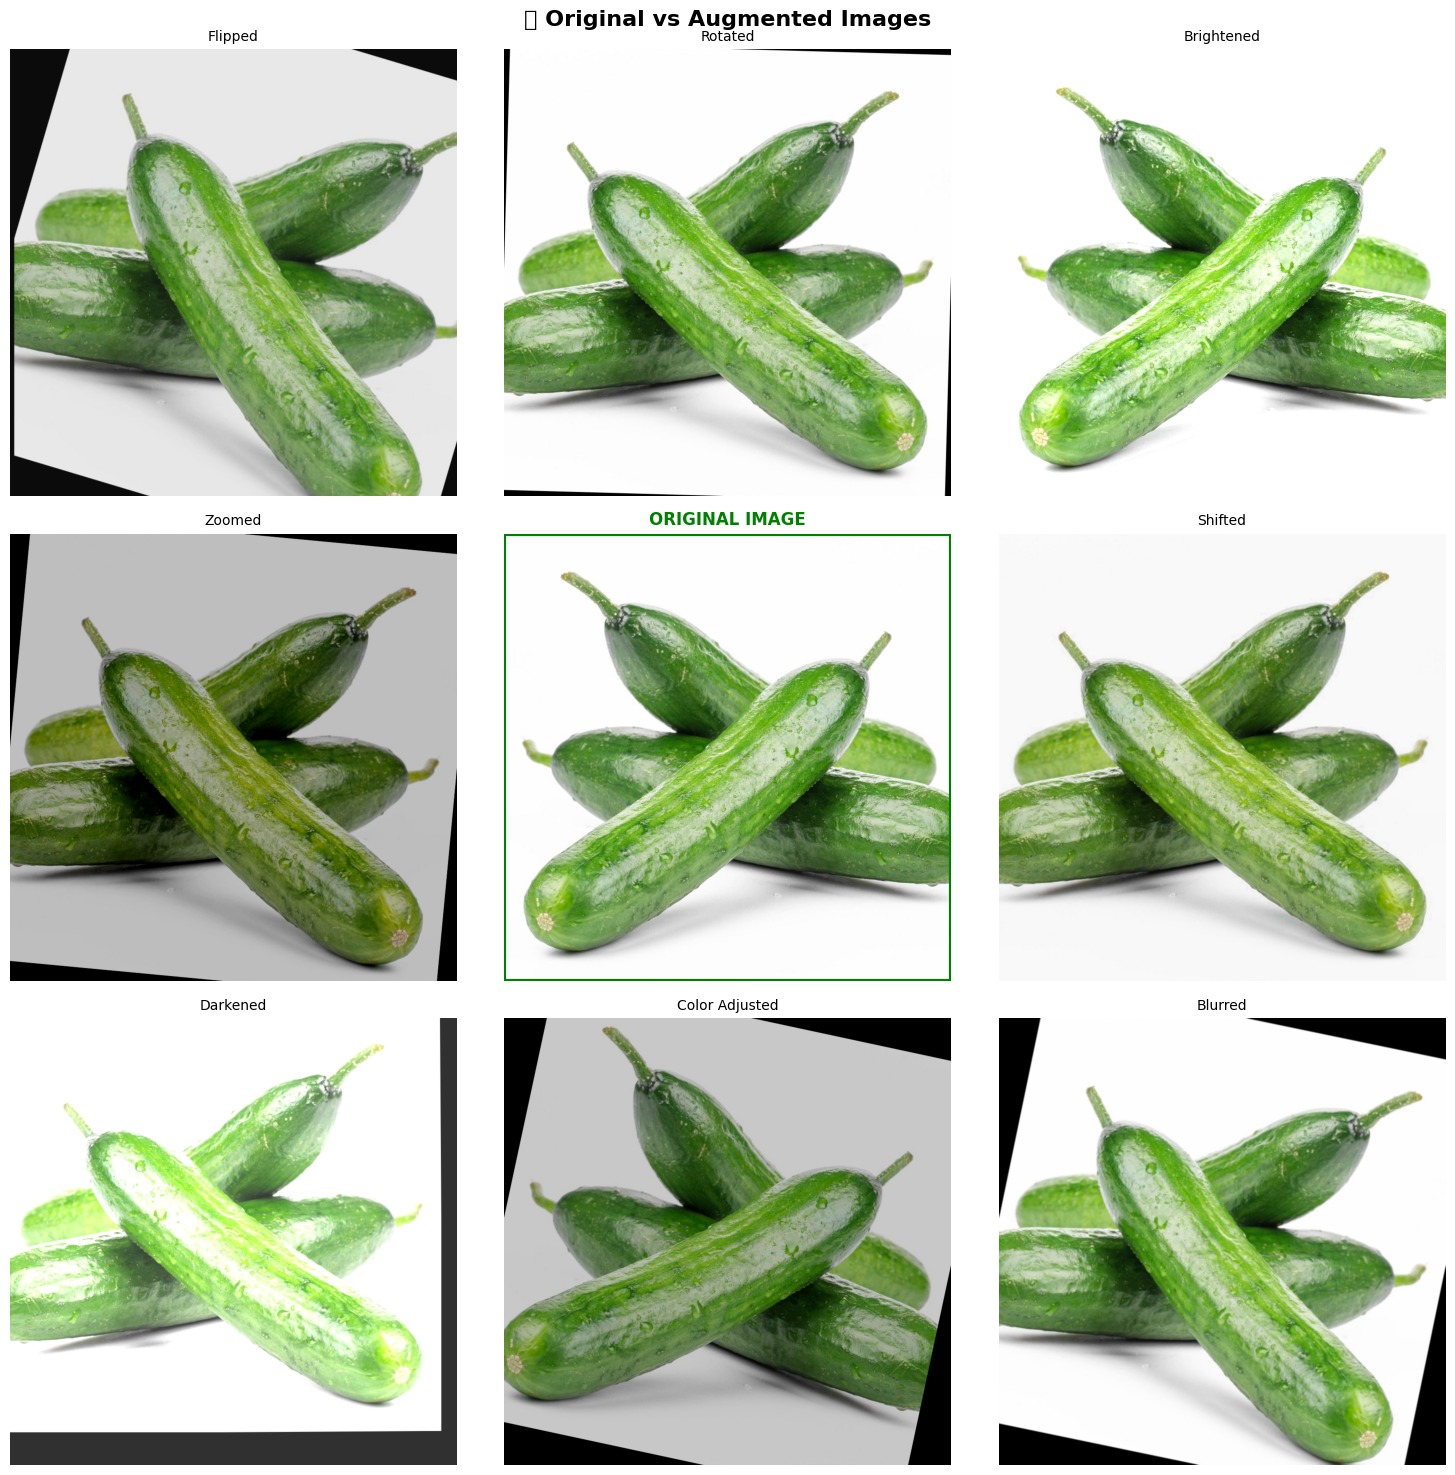

In [19]:
print("\n" + "=" * 70)
print("👀 SEEING AUGMENTATION IN ACTION")
print("=" * 70)

def show_augmentation_examples(image_path, num_augmentations=8):
    """Show original image and augmented versions"""

    # Read original image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create figure
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle('🎨 Original vs Augmented Images',
                 fontsize=16, fontweight='bold')

    # Show original in center
    axes[1, 1].imshow(image)
    axes[1, 1].set_title('ORIGINAL IMAGE', fontweight='bold',
                         fontsize=12, color='green')
    axes[1, 1].axis('off')
    axes[1, 1].add_patch(plt.Rectangle((0, 0), image.shape[1], image.shape[0],
                                       fill=False, edgecolor='green', linewidth=3))

    # Generate and show augmented versions
    positions = [(0, 0), (0, 1), (0, 2),
                 (1, 0), (1, 2),
                 (2, 0), (2, 1), (2, 2)]

    aug_names = [
        'Flipped', 'Rotated', 'Brightened',
        'Zoomed', 'Shifted', 'Darkened',
        'Color Adjusted', 'Blurred'
    ]

    for idx, (row, col) in enumerate(positions):
        augmented = augmentation_pipeline(image=image)['image']
        axes[row, col].imshow(augmented)
        axes[row, col].set_title(aug_names[idx], fontsize=10)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Pick a random image to demonstrate
random_category = random.choice(categories)
random_cat_path = os.path.join(TRAIN_PATH, random_category)
random_images = [f for f in os.listdir(random_cat_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
random_image = random.choice(random_images)
demo_image_path = os.path.join(random_cat_path, random_image)

print(f"\n📸 Showing augmentation examples using: {random_category}/{random_image}")
show_augmentation_examples(demo_image_path)

In [20]:
print("\n" + "=" * 70)
print("⚙️ AUGMENTATION SETTINGS")
print("=" * 70)

# How many augmented images to create per original image?
AUGMENTATIONS_PER_IMAGE = 3

print(f"""
📊 Current Settings:
   • Augmentations per image: {AUGMENTATIONS_PER_IMAGE}
   • Original images: Let's count...
""")

# Count original images
total_original = 0
for cat in categories:
    cat_path = os.path.join(TRAIN_PATH, cat)
    count = len([f for f in os.listdir(cat_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    total_original += count

total_after_augmentation = total_original + (total_original * AUGMENTATIONS_PER_IMAGE)

print(f"""
   • Total original images: {total_original}
   • New augmented images: {total_original * AUGMENTATIONS_PER_IMAGE}
   • Total after augmentation: {total_after_augmentation}

💡 If this seems too much, you can change AUGMENTATIONS_PER_IMAGE to 2 or 1
""")

# Ask user if they want to proceed
print("\n" + "=" * 70)
print("⏰ ESTIMATED TIME:")
print("=" * 70)
print(f"Creating {total_original * AUGMENTATIONS_PER_IMAGE} new images")
print(f"Estimated time: {(total_original * AUGMENTATIONS_PER_IMAGE) / 500:.1f} - {(total_original * AUGMENTATIONS_PER_IMAGE) / 300:.1f} minutes")
print("=" * 70)


⚙️ AUGMENTATION SETTINGS

📊 Current Settings:
   • Augmentations per image: 3
   • Original images: Let's count...


   • Total original images: 3115
   • New augmented images: 9345
   • Total after augmentation: 12460

💡 If this seems too much, you can change AUGMENTATIONS_PER_IMAGE to 2 or 1


⏰ ESTIMATED TIME:
Creating 9345 new images
Estimated time: 18.7 - 31.1 minutes


In [21]:
print("\n" + "=" * 70)
print("🚀 STARTING AUGMENTATION PROCESS")
print("=" * 70)

def augment_dataset(source_path, dest_path, categories, num_augmentations=3):
    """
    Create augmented versions of all images
    """

    augmentation_stats = {}

    for category in categories:
        print(f"\n📂 Processing category: {category.upper()}")

        # Create category folder in augmented path
        cat_source = os.path.join(source_path, category)
        cat_dest = os.path.join(dest_path, category)
        os.makedirs(cat_dest, exist_ok=True)

        # Get all images in this category
        images = [f for f in os.listdir(cat_source)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        original_count = len(images)
        augmented_count = 0

        # Process each image with progress bar
        for img_name in tqdm(images, desc=f"  Augmenting {category}"):
            img_path = os.path.join(cat_source, img_name)

            try:
                # Read image
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Save original image to new location
                original_save_path = os.path.join(cat_dest, f"orig_{img_name}")
                cv2.imwrite(original_save_path,
                           cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

                # Create augmented versions
                img_basename = os.path.splitext(img_name)[0]
                img_extension = os.path.splitext(img_name)[1]

                for i in range(num_augmentations):
                    # Apply augmentation
                    augmented = augmentation_pipeline(image=image)['image']

                    # Save augmented image
                    aug_name = f"aug{i+1}_{img_basename}{img_extension}"
                    aug_path = os.path.join(cat_dest, aug_name)
                    cv2.imwrite(aug_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))
                    augmented_count += 1

            except Exception as e:
                print(f"    ⚠️  Error with {img_name}: {str(e)}")
                continue

        # Store stats
        total_in_category = original_count + augmented_count
        augmentation_stats[category] = {
            'original': original_count,
            'augmented': augmented_count,
            'total': total_in_category
        }

        print(f"  ✅ {category}: {original_count} original + {augmented_count} augmented = {total_in_category} total")

    return augmentation_stats

# Run augmentation
print("\n🎨 Starting augmentation... (This will take several minutes)")
print("☕ Perfect time for a coffee break!\n")

stats = augment_dataset(TRAIN_PATH, AUGMENTED_PATH, categories, AUGMENTATIONS_PER_IMAGE)


🚀 STARTING AUGMENTATION PROCESS

🎨 Starting augmentation... (This will take several minutes)
☕ Perfect time for a coffee break!


📂 Processing category: APPLE


  Augmenting apple: 100%|██████████| 68/68 [00:11<00:00,  5.73it/s]


  ✅ apple: 68 original + 204 augmented = 272 total

📂 Processing category: BANANA


  Augmenting banana: 100%|██████████| 75/75 [00:12<00:00,  5.90it/s]


  ✅ banana: 75 original + 225 augmented = 300 total

📂 Processing category: BEETROOT


  Augmenting beetroot: 100%|██████████| 88/88 [00:09<00:00,  8.99it/s]


  ✅ beetroot: 88 original + 264 augmented = 352 total

📂 Processing category: BELL PEPPER


  Augmenting bell pepper: 100%|██████████| 90/90 [00:13<00:00,  6.49it/s]


  ✅ bell pepper: 90 original + 270 augmented = 360 total

📂 Processing category: CABBAGE


  Augmenting cabbage: 100%|██████████| 92/92 [00:09<00:00,  9.69it/s]


  ✅ cabbage: 92 original + 276 augmented = 368 total

📂 Processing category: CAPSICUM


  Augmenting capsicum: 100%|██████████| 89/89 [00:07<00:00, 12.12it/s]


  ✅ capsicum: 89 original + 267 augmented = 356 total

📂 Processing category: CARROT


  Augmenting carrot: 100%|██████████| 82/82 [00:06<00:00, 11.98it/s]


  ✅ carrot: 82 original + 246 augmented = 328 total

📂 Processing category: CAULIFLOWER


  Augmenting cauliflower: 100%|██████████| 79/79 [00:07<00:00, 11.08it/s]


  ✅ cauliflower: 79 original + 237 augmented = 316 total

📂 Processing category: CHILLI PEPPER


  Augmenting chilli pepper: 100%|██████████| 87/87 [00:06<00:00, 12.86it/s]


  ✅ chilli pepper: 87 original + 261 augmented = 348 total

📂 Processing category: CORN


  Augmenting corn: 100%|██████████| 87/87 [00:13<00:00,  6.53it/s]


  ✅ corn: 87 original + 261 augmented = 348 total

📂 Processing category: CUCUMBER


  Augmenting cucumber: 100%|██████████| 94/94 [00:13<00:00,  6.96it/s]


  ✅ cucumber: 94 original + 282 augmented = 376 total

📂 Processing category: EGGPLANT


  Augmenting eggplant: 100%|██████████| 84/84 [00:10<00:00,  8.10it/s]


  ✅ eggplant: 84 original + 252 augmented = 336 total

📂 Processing category: GARLIC


  Augmenting garlic: 100%|██████████| 92/92 [00:11<00:00,  8.23it/s]


  ✅ garlic: 92 original + 276 augmented = 368 total

📂 Processing category: GINGER


  Augmenting ginger: 100%|██████████| 68/68 [00:06<00:00,  9.94it/s]


  ✅ ginger: 68 original + 204 augmented = 272 total

📂 Processing category: GRAPES


  Augmenting grapes: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


  ✅ grapes: 100 original + 300 augmented = 400 total

📂 Processing category: JALEPENO


  Augmenting jalepeno: 100%|██████████| 88/88 [00:08<00:00, 10.52it/s]


  ✅ jalepeno: 88 original + 264 augmented = 352 total

📂 Processing category: KIWI


  Augmenting kiwi: 100%|██████████| 88/88 [00:09<00:00,  9.20it/s]


  ✅ kiwi: 88 original + 264 augmented = 352 total

📂 Processing category: LEMON


  Augmenting lemon: 100%|██████████| 82/82 [00:16<00:00,  4.89it/s]


  ✅ lemon: 82 original + 246 augmented = 328 total

📂 Processing category: LETTUCE


  Augmenting lettuce: 100%|██████████| 97/97 [00:15<00:00,  6.16it/s]


  ✅ lettuce: 97 original + 291 augmented = 388 total

📂 Processing category: MANGO


  Augmenting mango: 100%|██████████| 86/86 [00:08<00:00, 10.14it/s]


  ✅ mango: 86 original + 258 augmented = 344 total

📂 Processing category: ONION


  Augmenting onion: 100%|██████████| 94/94 [00:11<00:00,  7.87it/s]


  ✅ onion: 94 original + 282 augmented = 376 total

📂 Processing category: ORANGE


  Augmenting orange: 100%|██████████| 69/69 [00:15<00:00,  4.31it/s]


  ✅ orange: 69 original + 207 augmented = 276 total

📂 Processing category: PAPRIKA


  Augmenting paprika: 100%|██████████| 83/83 [00:09<00:00,  8.53it/s]


  ✅ paprika: 83 original + 249 augmented = 332 total

📂 Processing category: PEAR


  Augmenting pear: 100%|██████████| 89/89 [00:08<00:00,  9.92it/s]


  ✅ pear: 89 original + 267 augmented = 356 total

📂 Processing category: PEAS


  Augmenting peas: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


  ✅ peas: 100 original + 300 augmented = 400 total

📂 Processing category: PINEAPPLE


  Augmenting pineapple: 100%|██████████| 99/99 [00:22<00:00,  4.33it/s]


  ✅ pineapple: 99 original + 297 augmented = 396 total

📂 Processing category: POMEGRANATE


  Augmenting pomegranate: 100%|██████████| 79/79 [00:11<00:00,  7.03it/s]


  ✅ pomegranate: 79 original + 237 augmented = 316 total

📂 Processing category: POTATO


  Augmenting potato: 100%|██████████| 77/77 [00:06<00:00, 11.17it/s]


  ✅ potato: 77 original + 231 augmented = 308 total

📂 Processing category: RADDISH


  Augmenting raddish: 100%|██████████| 81/81 [00:04<00:00, 19.88it/s]


  ✅ raddish: 81 original + 243 augmented = 324 total

📂 Processing category: SOY BEANS


  Augmenting soy beans: 100%|██████████| 97/97 [00:06<00:00, 15.14it/s]


  ✅ soy beans: 97 original + 291 augmented = 388 total

📂 Processing category: SPINACH


  Augmenting spinach: 100%|██████████| 97/97 [00:11<00:00,  8.66it/s]


  ✅ spinach: 97 original + 291 augmented = 388 total

📂 Processing category: SWEETCORN


  Augmenting sweetcorn: 100%|██████████| 91/91 [00:06<00:00, 14.37it/s]


  ✅ sweetcorn: 91 original + 273 augmented = 364 total

📂 Processing category: SWEETPOTATO


  Augmenting sweetpotato: 100%|██████████| 69/69 [00:08<00:00,  7.80it/s]


  ✅ sweetpotato: 69 original + 207 augmented = 276 total

📂 Processing category: TOMATO


  Augmenting tomato: 100%|██████████| 92/92 [00:11<00:00,  7.91it/s]


  ✅ tomato: 92 original + 276 augmented = 368 total

📂 Processing category: TURNIP


  Augmenting turnip: 100%|██████████| 98/98 [00:07<00:00, 13.11it/s]


  ✅ turnip: 98 original + 294 augmented = 392 total

📂 Processing category: WATERMELON


  Augmenting watermelon: 100%|██████████| 84/84 [00:16<00:00,  5.15it/s]

  ✅ watermelon: 84 original + 252 augmented = 336 total


In [22]:
print("\n" + "=" * 70)
print("🎉 AUGMENTATION COMPLETE!")
print("=" * 70)

# Calculate totals
total_original_final = sum(s['original'] for s in stats.values())
total_augmented_final = sum(s['augmented'] for s in stats.values())
total_final = sum(s['total'] for s in stats.values())

print(f"\n📊 AUGMENTATION SUMMARY:")
print("-" * 70)
print(f"Original images:    {total_original_final:,}")
print(f"Augmented images:   {total_augmented_final:,}")
print(f"TOTAL IMAGES NOW:   {total_final:,}")
print(f"Increase:           {(total_augmented_final/total_original_final)*100:.1f}% more data!")
print("-" * 70)

print(f"\n📁 CATEGORY BREAKDOWN:")
print("-" * 70)
for cat, stat in stats.items():
    print(f"{cat:25s} → {stat['original']:4d} + {stat['augmented']:4d} = {stat['total']:5d} images")
print("-" * 70)

# Save statistics
stats_path = os.path.join(AUGMENTED_PATH, 'augmentation_stats.json')
with open(stats_path, 'w') as f:
    json.dump(stats, f, indent=2)

print(f"\n✅ Statistics saved to: {stats_path}")



🎉 AUGMENTATION COMPLETE!

📊 AUGMENTATION SUMMARY:
----------------------------------------------------------------------
Original images:    3,115
Augmented images:   9,345
TOTAL IMAGES NOW:   12,460
Increase:           300.0% more data!
----------------------------------------------------------------------

📁 CATEGORY BREAKDOWN:
----------------------------------------------------------------------
apple                     →   68 +  204 =   272 images
banana                    →   75 +  225 =   300 images
beetroot                  →   88 +  264 =   352 images
bell pepper               →   90 +  270 =   360 images
cabbage                   →   92 +  276 =   368 images
capsicum                  →   89 +  267 =   356 images
carrot                    →   82 +  246 =   328 images
cauliflower               →   79 +  237 =   316 images
chilli pepper             →   87 +  261 =   348 images
corn                      →   87 +  261 =   348 images
cucumber                  →   94 +  282 =   37

In [23]:
print("\n" + "=" * 70)
print("📊 BEFORE & AFTER COMPARISON")
print("=" * 70)

def show_before_after_samples(category, num_samples=3):
    """Show original and augmented versions side by side"""

    cat_path = os.path.join(AUGMENTED_PATH, category)
    all_images = sorted([f for f in os.listdir(cat_path)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    # Get original images
    original_images = [img for img in all_images if img.startswith('orig_')]
    sample_originals = random.sample(original_images,
                                     min(num_samples, len(original_images)))

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    fig.suptitle(f'🔍 Before & After: {category.upper()}',
                 fontsize=16, fontweight='bold')

    for i, orig_name in enumerate(sample_originals):
        # Load original
        orig_path = os.path.join(cat_path, orig_name)
        orig_img = cv2.imread(orig_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

        # Find augmented versions
        base_name = orig_name.replace('orig_', '')
        base_name_no_ext = os.path.splitext(base_name)[0]
        ext = os.path.splitext(base_name)[1]

        aug_images = [
            f"aug1_{base_name_no_ext}{ext}",
            f"aug2_{base_name_no_ext}{ext}",
            f"aug3_{base_name_no_ext}{ext}"
        ]

        # Show original
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title('ORIGINAL', fontweight='bold', color='green')
        axes[i, 0].axis('off')

        # Show augmented versions
        for j, aug_name in enumerate(aug_images, 1):
            aug_path = os.path.join(cat_path, aug_name)
            if os.path.exists(aug_path):
                aug_img = cv2.imread(aug_path)
                aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
                axes[i, j].imshow(aug_img)
                axes[i, j].set_title(f'AUGMENTED {j}', fontsize=10)
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Show samples from 3 random categories
print("\n🖼️  Showing before & after examples...")
sample_categories = random.sample(categories, min(3, len(categories)))

for cat in sample_categories:
    show_before_after_samples(cat, num_samples=2)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
print("\n" + "=" * 70)
print("✅ DATA AUGMENTATION COMPLETE!")
print("=" * 70)

print(f"""
🎉 SUCCESS! Your dataset is now {(total_augmented_final/total_original_final)*100:.1f}% BIGGER!

📊 WHAT WE DID:
   ✅ Created {total_augmented_final:,} new augmented images
   ✅ Applied 7 different transformations (flip, rotate, brightness, etc.)
   ✅ Saved everything to: {AUGMENTED_PATH}
   ✅ Kept original images safely

📁 YOUR NEW DATASET:
   • Location: {AUGMENTED_PATH}
   • Total images: {total_final:,}
   • Categories: {len(categories)}
   • Ready for training: YES! ✅

🎯 NEXT STEPS:
   1. Split data into Train (80%) and Validation (20%) sets
   2. Build CNN model (MobileNetV2 or ResNet)
   3. Train the model
   4. Test accuracy

💡 Your AI will now be much smarter because it learned to recognize fruits:
   • When flipped or rotated
   • In different lighting conditions
   • With different color tones
   • From different angles

Ready for the next step? Just say "Split the data!" 🚀
""")

print("=" * 70)


✅ DATA AUGMENTATION COMPLETE!

🎉 SUCCESS! Your dataset is now 300.0% BIGGER!

📊 WHAT WE DID:
   ✅ Created 9,345 new augmented images
   ✅ Applied 7 different transformations (flip, rotate, brightness, etc.)
   ✅ Saved everything to: /content/fruit_dataset/augmented_data
   ✅ Kept original images safely

📁 YOUR NEW DATASET:
   • Location: /content/fruit_dataset/augmented_data
   • Total images: 12,460
   • Categories: 36
   • Ready for training: YES! ✅

🎯 NEXT STEPS:
   1. Split data into Train (80%) and Validation (20%) sets
   2. Build CNN model (MobileNetV2 or ResNet)
   3. Train the model
   4. Test accuracy

💡 Your AI will now be much smarter because it learned to recognize fruits:
   • When flipped or rotated
   • In different lighting conditions
   • With different color tones
   • From different angles

Ready for the next step? Just say "Split the data!" 🚀



In [27]:
print("=" * 70)
print("📊 TRAIN/TEST SPLIT - ORGANIZING DATA FOR AI TRAINING")
print("=" * 70)

import os
import shutil
import random
from pathlib import Path
import matplotlib.pyplot as plt
import json
from collections import Counter
import numpy as np

print("✅ Libraries loaded successfully!")

📊 TRAIN/TEST SPLIT - ORGANIZING DATA FOR AI TRAINING
✅ Libraries loaded successfully!


In [28]:
print("\n" + "=" * 70)
print("📁 SETTING UP FOLDERS")
print("=" * 70)

# Source path (augmented data from previous step)
SOURCE_PATH = '/content/fruit_dataset/augmented_data'

# Destination paths for split data
SPLIT_DATA_PATH = '/content/fruit_dataset/split_data'
TRAIN_PATH = os.path.join(SPLIT_DATA_PATH, 'train')
VAL_PATH = os.path.join(SPLIT_DATA_PATH, 'validation')

# Create folders
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VAL_PATH, exist_ok=True)

print(f"✅ Source (Augmented Data): {SOURCE_PATH}")
print(f"✅ Training Set (80%): {TRAIN_PATH}")
print(f"✅ Validation Set (20%): {VAL_PATH}")

# Get all categories
categories = sorted([d for d in os.listdir(SOURCE_PATH)
                    if os.path.isdir(os.path.join(SOURCE_PATH, d))])
print(f"✅ Found {len(categories)} categories")


📁 SETTING UP FOLDERS
✅ Source (Augmented Data): /content/fruit_dataset/augmented_data
✅ Training Set (80%): /content/fruit_dataset/split_data/train
✅ Validation Set (20%): /content/fruit_dataset/split_data/validation
✅ Found 36 categories


In [29]:
print("\n" + "=" * 70)
print("🧠 WHY DO WE SPLIT DATA? (Simple Explanation)")
print("=" * 70)

print("""
Imagine you're a teacher teaching a student:

📚 TRAINING SET (80%) - Learning Phase
   • Student studies these examples
   • Learns patterns and features
   • Like: "Bananas are yellow and curved"

📝 VALIDATION SET (20%) - Testing Phase
   • Student takes a test with NEW examples
   • Checks if they REALLY learned
   • Prevents memorization, ensures understanding

🎯 WHY NOT 100% FOR TRAINING?
   If you only show the same images during training, the AI might just
   MEMORIZE them instead of LEARNING the patterns. It's like a student
   who memorizes answers but doesn't understand the concepts!

   By testing on UNSEEN images (20%), we make sure the AI actually
   LEARNED to recognize fruits, not just memorized the training pictures!
""")

print("\n" + "=" * 70)
print("📊 SPLIT RATIO SETTINGS")
print("=" * 70)

# Split ratio
TRAIN_RATIO = 0.8  # 80% for training
VAL_RATIO = 0.2    # 20% for validation

print(f"""
Current Settings:
   • Training Set: {TRAIN_RATIO * 100:.0f}%
   • Validation Set: {VAL_RATIO * 100:.0f}%

💡 This is the STANDARD split used by most AI researchers!
""")


🧠 WHY DO WE SPLIT DATA? (Simple Explanation)

Imagine you're a teacher teaching a student:

📚 TRAINING SET (80%) - Learning Phase
   • Student studies these examples
   • Learns patterns and features
   • Like: "Bananas are yellow and curved"

📝 VALIDATION SET (20%) - Testing Phase  
   • Student takes a test with NEW examples
   • Checks if they REALLY learned
   • Prevents memorization, ensures understanding

🎯 WHY NOT 100% FOR TRAINING?
   If you only show the same images during training, the AI might just
   MEMORIZE them instead of LEARNING the patterns. It's like a student
   who memorizes answers but doesn't understand the concepts!

   By testing on UNSEEN images (20%), we make sure the AI actually
   LEARNED to recognize fruits, not just memorized the training pictures!


📊 SPLIT RATIO SETTINGS

Current Settings:
   • Training Set: 80%
   • Validation Set: 20%

💡 This is the STANDARD split used by most AI researchers!



In [30]:
print("\n" + "=" * 70)
print("🔢 COUNTING IMAGES BEFORE SPLIT")
print("=" * 70)

category_counts = {}
for cat in categories:
    cat_path = os.path.join(SOURCE_PATH, cat)
    images = [f for f in os.listdir(cat_path)
             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    category_counts[cat] = len(images)

total_images = sum(category_counts.values())

print(f"\n📊 Total Images: {total_images:,}")
print(f"\nBreakdown by category:")
print("-" * 70)
for cat, count in list(category_counts.items())[:10]:
    print(f"   {cat:25s} → {count:5d} images")
if len(categories) > 10:
    print(f"   ... and {len(categories) - 10} more categories")
print("-" * 70)

# Calculate expected split
expected_train = int(total_images * TRAIN_RATIO)
expected_val = int(total_images * VAL_RATIO)

print(f"\n📈 Expected After Split:")
print(f"   Training Set (80%):   {expected_train:,} images")
print(f"   Validation Set (20%): {expected_val:,} images")



🔢 COUNTING IMAGES BEFORE SPLIT

📊 Total Images: 12,460

Breakdown by category:
----------------------------------------------------------------------
   apple                     →   272 images
   banana                    →   300 images
   beetroot                  →   352 images
   bell pepper               →   360 images
   cabbage                   →   368 images
   capsicum                  →   356 images
   carrot                    →   328 images
   cauliflower               →   316 images
   chilli pepper             →   348 images
   corn                      →   348 images
   ... and 26 more categories
----------------------------------------------------------------------

📈 Expected After Split:
   Training Set (80%):   9,968 images
   Validation Set (20%): 2,492 images



📊 VISUALIZING THE SPLIT

📊 Generating visualization...


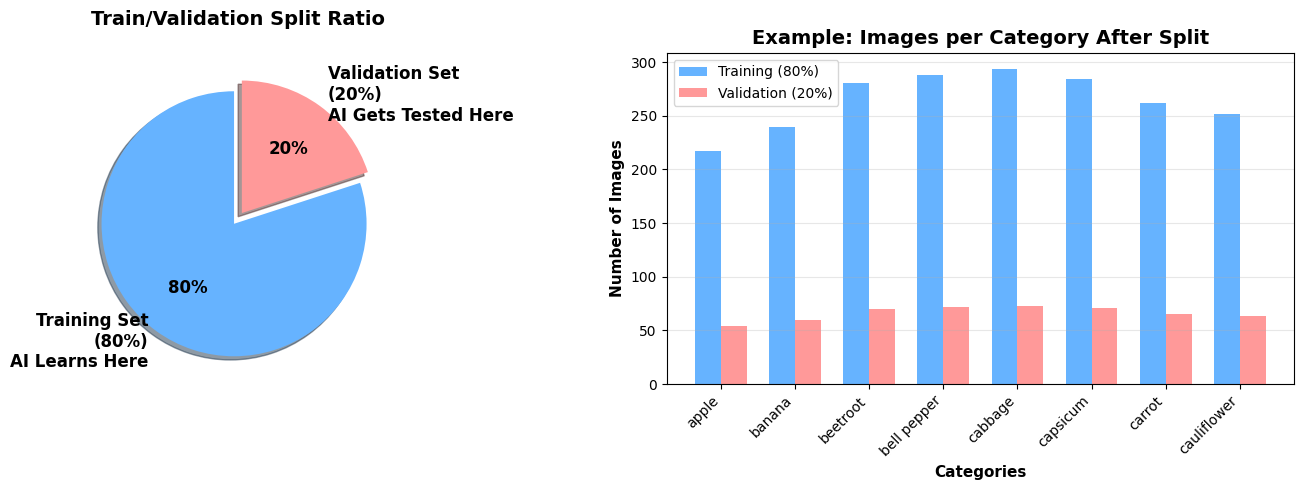

In [31]:
print("\n" + "=" * 70)
print("📊 VISUALIZING THE SPLIT")
print("=" * 70)

def visualize_split_concept():
    """Show a pie chart of the train/val split"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Pie chart showing split
    sizes = [80, 20]
    labels = ['Training Set\n(80%)\nAI Learns Here',
              'Validation Set\n(20%)\nAI Gets Tested Here']
    colors = ['#66b3ff', '#ff9999']
    explode = (0.05, 0.05)

    ax1.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.0f%%', shadow=True, startangle=90,
            textprops={'fontsize': 12, 'weight': 'bold'})
    ax1.set_title('Train/Validation Split Ratio',
                  fontsize=14, fontweight='bold', pad=20)

    # Bar chart showing image counts
    categories_sample = list(category_counts.keys())[:8]
    counts_sample = [category_counts[cat] for cat in categories_sample]
    train_counts = [int(c * 0.8) for c in counts_sample]
    val_counts = [int(c * 0.2) for c in counts_sample]

    x = np.arange(len(categories_sample))
    width = 0.35

    ax2.bar(x - width/2, train_counts, width, label='Training (80%)',
            color='#66b3ff')
    ax2.bar(x + width/2, val_counts, width, label='Validation (20%)',
            color='#ff9999')

    ax2.set_xlabel('Categories', fontweight='bold', fontsize=11)
    ax2.set_ylabel('Number of Images', fontweight='bold', fontsize=11)
    ax2.set_title('Example: Images per Category After Split',
                  fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories_sample, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\n📊 Generating visualization...")
visualize_split_concept()

In [32]:
print("\n" + "=" * 70)
print("✂️ SPLITTING DATA INTO TRAIN AND VALIDATION SETS")
print("=" * 70)

def split_data(source_path, train_path, val_path, categories, train_ratio=0.8):
    """
    Split images from source into train and validation sets
    """

    split_stats = {}

    # Set random seed for reproducibility
    random.seed(42)

    print("\n🔄 Processing each category...")
    print("-" * 70)

    for idx, category in enumerate(categories, 1):
        print(f"\n[{idx}/{len(categories)}] 📂 Processing: {category.upper()}")

        # Source category path
        source_cat_path = os.path.join(source_path, category)

        # Destination category paths
        train_cat_path = os.path.join(train_path, category)
        val_cat_path = os.path.join(val_path, category)

        # Create destination folders
        os.makedirs(train_cat_path, exist_ok=True)
        os.makedirs(val_cat_path, exist_ok=True)

        # Get all images
        all_images = [f for f in os.listdir(source_cat_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Shuffle images randomly
        random.shuffle(all_images)

        # Calculate split point
        split_point = int(len(all_images) * train_ratio)

        # Split images
        train_images = all_images[:split_point]
        val_images = all_images[split_point:]

        # Copy training images
        print(f"   📋 Copying {len(train_images)} images to TRAINING set...", end=' ')
        for img in train_images:
            src = os.path.join(source_cat_path, img)
            dst = os.path.join(train_cat_path, img)
            shutil.copy2(src, dst)
        print("✅")

        # Copy validation images
        print(f"   📋 Copying {len(val_images)} images to VALIDATION set...", end=' ')
        for img in val_images:
            src = os.path.join(source_cat_path, img)
            dst = os.path.join(val_cat_path, img)
            shutil.copy2(src, dst)
        print("✅")

        # Store statistics
        split_stats[category] = {
            'total': len(all_images),
            'train': len(train_images),
            'validation': len(val_images),
            'train_percentage': (len(train_images) / len(all_images)) * 100,
            'val_percentage': (len(val_images) / len(all_images)) * 100
        }

        print(f"   ✅ {category}: {len(train_images)} train + {len(val_images)} val = {len(all_images)} total")

    return split_stats

# Perform the split
print("\n🚀 Starting data split... (This will take 2-5 minutes)")
print("⏰ Copying files to train and validation folders...\n")

split_statistics = split_data(SOURCE_PATH, TRAIN_PATH, VAL_PATH,
                               categories, TRAIN_RATIO)


✂️ SPLITTING DATA INTO TRAIN AND VALIDATION SETS

🚀 Starting data split... (This will take 2-5 minutes)
⏰ Copying files to train and validation folders...


🔄 Processing each category...
----------------------------------------------------------------------

[1/36] 📂 Processing: APPLE
   📋 Copying 217 images to TRAINING set... ✅
   📋 Copying 55 images to VALIDATION set... ✅
   ✅ apple: 217 train + 55 val = 272 total

[2/36] 📂 Processing: BANANA
   📋 Copying 240 images to TRAINING set... ✅
   📋 Copying 60 images to VALIDATION set... ✅
   ✅ banana: 240 train + 60 val = 300 total

[3/36] 📂 Processing: BEETROOT
   📋 Copying 281 images to TRAINING set... ✅
   📋 Copying 71 images to VALIDATION set... ✅
   ✅ beetroot: 281 train + 71 val = 352 total

[4/36] 📂 Processing: BELL PEPPER
   📋 Copying 288 images to TRAINING set... ✅
   📋 Copying 72 images to VALIDATION set... ✅
   ✅ bell pepper: 288 train + 72 val = 360 total

[5/36] 📂 Processing: CABBAGE
   📋 Copying 294 images to TRAINING set... 

In [33]:
print("\n" + "=" * 70)
print("✅ VERIFYING THE SPLIT")
print("=" * 70)

# Count files in train and validation sets
train_total = 0
val_total = 0

for cat in categories:
    train_cat_path = os.path.join(TRAIN_PATH, cat)
    val_cat_path = os.path.join(VAL_PATH, cat)

    train_count = len([f for f in os.listdir(train_cat_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    val_count = len([f for f in os.listdir(val_cat_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    train_total += train_count
    val_total += val_count

grand_total = train_total + val_total

print(f"\n📊 FINAL COUNTS:")
print("-" * 70)
print(f"Training Set:     {train_total:,} images ({(train_total/grand_total)*100:.1f}%)")
print(f"Validation Set:   {val_total:,} images ({(val_total/grand_total)*100:.1f}%)")
print(f"TOTAL:            {grand_total:,} images (100%)")
print("-" * 70)

# Check if split is correct
if abs((train_total/grand_total) - TRAIN_RATIO) < 0.01:
    print("✅ Split ratio is CORRECT!")
else:
    print("⚠️  Split ratio slightly off (but this is normal due to rounding)")


✅ VERIFYING THE SPLIT

📊 FINAL COUNTS:
----------------------------------------------------------------------
Training Set:     9,950 images (79.9%)
Validation Set:   2,510 images (20.1%)
TOTAL:            12,460 images (100%)
----------------------------------------------------------------------
✅ Split ratio is CORRECT!


In [34]:
print("\n" + "=" * 70)
print("📈 DETAILED STATISTICS BY CATEGORY")
print("=" * 70)

print(f"\n{'Category':<25} {'Total':<8} {'Train':<8} {'Val':<8} {'Split %':<12}")
print("-" * 70)

for cat, stats in list(split_statistics.items())[:15]:
    print(f"{cat:<25} {stats['total']:<8} {stats['train']:<8} "
          f"{stats['validation']:<8} {stats['train_percentage']:.1f}/{stats['val_percentage']:.1f}")

if len(split_statistics) > 15:
    print(f"... and {len(split_statistics) - 15} more categories")
print("-" * 70)



📈 DETAILED STATISTICS BY CATEGORY

Category                  Total    Train    Val      Split %     
----------------------------------------------------------------------
apple                     272      217      55       79.8/20.2
banana                    300      240      60       80.0/20.0
beetroot                  352      281      71       79.8/20.2
bell pepper               360      288      72       80.0/20.0
cabbage                   368      294      74       79.9/20.1
capsicum                  356      284      72       79.8/20.2
carrot                    328      262      66       79.9/20.1
cauliflower               316      252      64       79.7/20.3
chilli pepper             348      278      70       79.9/20.1
corn                      348      278      70       79.9/20.1
cucumber                  376      300      76       79.8/20.2
eggplant                  336      268      68       79.8/20.2
garlic                    368      294      74       79.9/20.1
ginger  


📊 VISUALIZING FINAL DISTRIBUTION

📊 Generating final distribution chart...


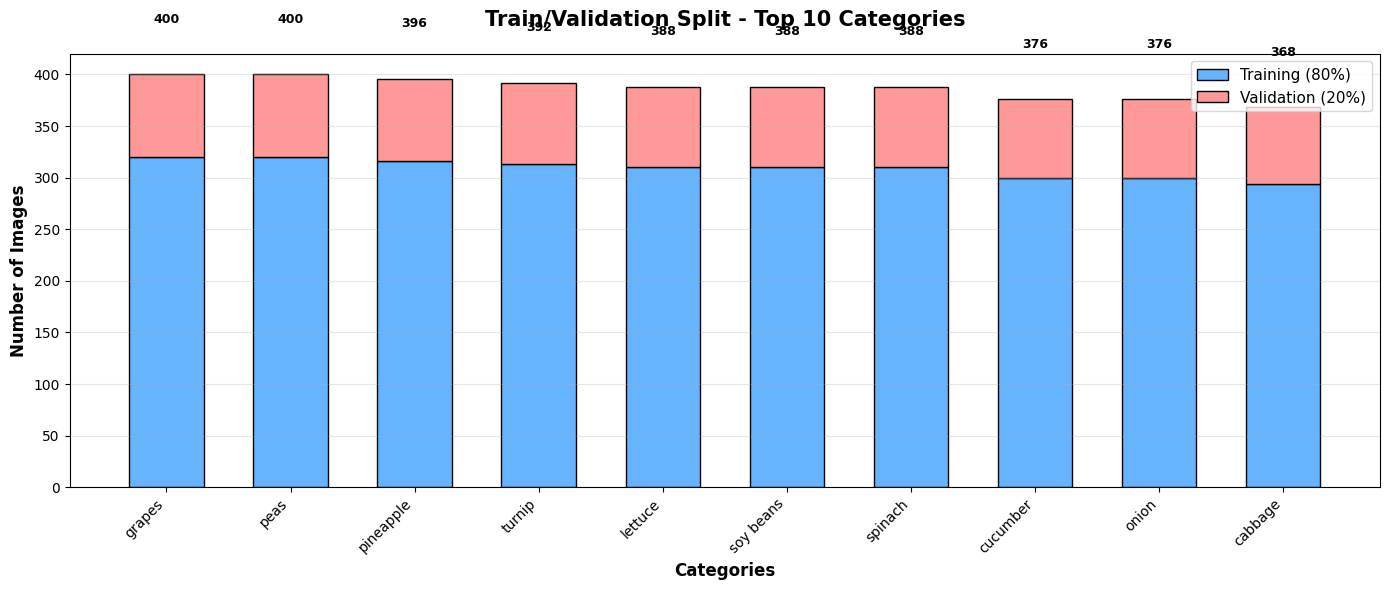

In [35]:
print("\n" + "=" * 70)
print("📊 VISUALIZING FINAL DISTRIBUTION")
print("=" * 70)

def visualize_final_distribution(split_stats):
    """Show bar charts of train/val distribution"""

    # Prepare data for top 10 categories
    top_categories = sorted(split_stats.items(),
                           key=lambda x: x[1]['total'],
                           reverse=True)[:10]

    cat_names = [cat for cat, _ in top_categories]
    train_counts = [stats['train'] for _, stats in top_categories]
    val_counts = [stats['validation'] for _, stats in top_categories]

    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 6))

    x = np.arange(len(cat_names))
    width = 0.6

    p1 = ax.bar(x, train_counts, width, label='Training (80%)',
                color='#66b3ff', edgecolor='black', linewidth=1)
    p2 = ax.bar(x, val_counts, width, bottom=train_counts,
                label='Validation (20%)', color='#ff9999',
                edgecolor='black', linewidth=1)

    ax.set_xlabel('Categories', fontweight='bold', fontsize=12)
    ax.set_ylabel('Number of Images', fontweight='bold', fontsize=12)
    ax.set_title('Train/Validation Split - Top 10 Categories',
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(cat_names, rotation=45, ha='right')
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, (train, val) in enumerate(zip(train_counts, val_counts)):
        total = train + val
        ax.text(i, total + 50, f'{total}', ha='center',
                fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.show()

print("\n📊 Generating final distribution chart...")
visualize_final_distribution(split_statistics)

In [36]:
print("\n" + "=" * 70)
print("💾 SAVING SPLIT INFORMATION")
print("=" * 70)

# Save split statistics
split_info = {
    'train_ratio': TRAIN_RATIO,
    'val_ratio': VAL_RATIO,
    'train_total': train_total,
    'val_total': val_total,
    'grand_total': grand_total,
    'num_categories': len(categories),
    'categories': list(categories),
    'detailed_stats': split_statistics
}

split_info_path = os.path.join(SPLIT_DATA_PATH, 'split_info.json')
with open(split_info_path, 'w') as f:
    json.dump(split_info, f, indent=2)

print(f"✅ Split information saved to: {split_info_path}")

# Create a simple text summary
summary_path = os.path.join(SPLIT_DATA_PATH, 'SPLIT_SUMMARY.txt')
with open(summary_path, 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("CHECKN GO - TRAIN/VALIDATION SPLIT SUMMARY\n")
    f.write("=" * 70 + "\n\n")
    f.write(f"Training Set:     {train_total:,} images ({(train_total/grand_total)*100:.1f}%)\n")
    f.write(f"Validation Set:   {val_total:,} images ({(val_total/grand_total)*100:.1f}%)\n")
    f.write(f"TOTAL:            {grand_total:,} images\n\n")
    f.write("=" * 70 + "\n")
    f.write("FOLDER STRUCTURE:\n")
    f.write("=" * 70 + "\n\n")
    f.write("split_data/\n")
    f.write("├── train/\n")
    f.write("│   ├── apple/\n")
    f.write("│   ├── banana/\n")
    f.write("│   └── ... (36 categories)\n")
    f.write("└── validation/\n")
    f.write("    ├── apple/\n")
    f.write("    ├── banana/\n")
    f.write("    └── ... (36 categories)\n")

print(f"✅ Text summary saved to: {summary_path}")


💾 SAVING SPLIT INFORMATION
✅ Split information saved to: /content/fruit_dataset/split_data/split_info.json
✅ Text summary saved to: /content/fruit_dataset/split_data/SPLIT_SUMMARY.txt


In [37]:
print("\n" + "=" * 70)
print("🎉 TRAIN/TEST SPLIT COMPLETE!")
print("=" * 70)

print(f"""
✅ DATA SPLIT SUCCESSFUL!

📊 FINAL NUMBERS:
   • Training Set:     {train_total:,} images (80%)
   • Validation Set:   {val_total:,} images (20%)
   • Total Images:     {grand_total:,}
   • Categories:       {len(categories)}

📁 YOUR DATA IS NOW ORGANIZED:
   {SPLIT_DATA_PATH}/
   ├── train/ (for teaching the AI)
   │   ├── apple/
   │   ├── banana/
   │   └── ... (all categories)
   └── validation/ (for testing the AI)
       ├── apple/
       ├── banana/
       └── ... (all categories)

🎯 WHY THIS MATTERS:
   ✅ Training set = AI learns patterns from these images
   ✅ Validation set = We test if AI REALLY learned (not just memorized!)
   ✅ Proper split = Better, more reliable AI model

📚 WHAT WE DID:
   1. ✅ Took all augmented images
   2. ✅ Randomly shuffled them
   3. ✅ Split 80% for training, 20% for validation
   4. ✅ Organized into proper folders
   5. ✅ Verified the split is correct

🚀 NEXT STEPS:
   1. Build CNN Model (MobileNetV2 or ResNet50)
   2. Train the model on training set
   3. Validate accuracy on validation set
   4. Save the trained model
   5. Use it in your ChecknGo system!

💡 YOUR DATA IS NOW READY FOR AI TRAINING!

Ready to build and train your AI model? Just say "Build the model!" 🧠
""")

print("=" * 70)


🎉 TRAIN/TEST SPLIT COMPLETE!

✅ DATA SPLIT SUCCESSFUL!

📊 FINAL NUMBERS:
   • Training Set:     9,950 images (80%)
   • Validation Set:   2,510 images (20%)
   • Total Images:     12,460
   • Categories:       36

📁 YOUR DATA IS NOW ORGANIZED:
   /content/fruit_dataset/split_data/
   ├── train/ (for teaching the AI)
   │   ├── apple/
   │   ├── banana/
   │   └── ... (all categories)
   └── validation/ (for testing the AI)
       ├── apple/
       ├── banana/
       └── ... (all categories)

🎯 WHY THIS MATTERS:
   ✅ Training set = AI learns patterns from these images
   ✅ Validation set = We test if AI REALLY learned (not just memorized!)
   ✅ Proper split = Better, more reliable AI model

📚 WHAT WE DID:
   1. ✅ Took all augmented images
   2. ✅ Randomly shuffled them
   3. ✅ Split 80% for training, 20% for validation
   4. ✅ Organized into proper folders
   5. ✅ Verified the split is correct

🚀 NEXT STEPS:
   1. Build CNN Model (MobileNetV2 or ResNet50)
   2. Train the model on train

In [38]:
print("=" * 70)
print("🧠 BUILDING AI MODEL - CREATING THE FRUIT RECOGNITION BRAIN")
print("=" * 70)

print("\n📦 Installing TensorFlow and Keras...")
!pip install -q tensorflow keras matplotlib scikit-learn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from datetime import datetime

print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ Keras version: {keras.__version__}")

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("✅ GPU detected! Training will be FAST! 🚀")
else:
    print("ℹ️  Using CPU (training will be slower, but still works!)")

🧠 BUILDING AI MODEL - CREATING THE FRUIT RECOGNITION BRAIN

📦 Installing TensorFlow and Keras...
✅ TensorFlow version: 2.19.0
✅ Keras version: 3.10.0
ℹ️  Using CPU (training will be slower, but still works!)


In [39]:
print("\n" + "=" * 70)
print("⚙️ SETTING UP PARAMETERS")
print("=" * 70)

# Data paths
TRAIN_PATH = '/content/fruit_dataset/split_data/train'
VAL_PATH = '/content/fruit_dataset/split_data/validation'
MODEL_SAVE_PATH = '/content/fruit_dataset/models'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Model parameters
IMG_SIZE = 224  # MobileNetV2 expects 224x224 images
BATCH_SIZE = 32  # How many images to process at once
EPOCHS = 20  # How many times to go through all training data
LEARNING_RATE = 0.001  # How fast the AI learns

# Count categories
categories = sorted([d for d in os.listdir(TRAIN_PATH)
                    if os.path.isdir(os.path.join(TRAIN_PATH, d))])
NUM_CLASSES = len(categories)

print(f"""
📊 MODEL CONFIGURATION:
   • Image Size: {IMG_SIZE}x{IMG_SIZE} pixels
   • Batch Size: {BATCH_SIZE} images per batch
   • Epochs: {EPOCHS} training rounds
   • Learning Rate: {LEARNING_RATE}
   • Number of Classes: {NUM_CLASSES} (fruit/vegetable types)

💡 These are STANDARD values used by AI researchers!
""")


⚙️ SETTING UP PARAMETERS

📊 MODEL CONFIGURATION:
   • Image Size: 224x224 pixels
   • Batch Size: 32 images per batch
   • Epochs: 20 training rounds
   • Learning Rate: 0.001
   • Number of Classes: 36 (fruit/vegetable types)
   
💡 These are STANDARD values used by AI researchers!



In [40]:
print("\n" + "=" * 70)
print("🧠 WHAT IS A CNN? (Kid-Friendly Explanation)")
print("=" * 70)

print("""
CNN = Convolutional Neural Network = AI's "Eyes and Brain"

Imagine teaching a kid to recognize fruits:

👀 STEP 1: LOOK AT DETAILS (Convolutional Layers)
   • Kid notices: "It's round"
   • Kid sees: "It's yellow"
   • Kid spots: "It has a curved shape"

🧠 STEP 2: REMEMBER PATTERNS (Pooling Layers)
   • Kid thinks: "Round + Yellow + Curved = probably a BANANA!"
   • Kid learns: "Small + Red + Round = probably a CHERRY!"

🎯 STEP 3: MAKE DECISION (Dense Layers)
   • Kid decides: "This is definitely a BANANA!"
   • Kid is confident: "95% sure it's a banana!"

🔄 HOW IT LEARNS:
   1. Show picture → Kid guesses
   2. Tell if correct or wrong
   3. Kid adjusts their understanding
   4. Repeat 1000s of times
   5. Kid becomes EXPERT! 🎓

📚 OUR MODEL (MobileNetV2):
   • Pre-trained on 1 MILLION images!
   • Already knows shapes, colors, textures
   • We just teach it OUR specific fruits!
   • This is called "TRANSFER LEARNING" (smart shortcut!)
""")


🧠 WHAT IS A CNN? (Kid-Friendly Explanation)

CNN = Convolutional Neural Network = AI's "Eyes and Brain"

Imagine teaching a kid to recognize fruits:

👀 STEP 1: LOOK AT DETAILS (Convolutional Layers)
   • Kid notices: "It's round"
   • Kid sees: "It's yellow"
   • Kid spots: "It has a curved shape"

🧠 STEP 2: REMEMBER PATTERNS (Pooling Layers)
   • Kid thinks: "Round + Yellow + Curved = probably a BANANA!"
   • Kid learns: "Small + Red + Round = probably a CHERRY!"

🎯 STEP 3: MAKE DECISION (Dense Layers)
   • Kid decides: "This is definitely a BANANA!"
   • Kid is confident: "95% sure it's a banana!"

🔄 HOW IT LEARNS:
   1. Show picture → Kid guesses
   2. Tell if correct or wrong
   3. Kid adjusts their understanding
   4. Repeat 1000s of times
   5. Kid becomes EXPERT! 🎓

📚 OUR MODEL (MobileNetV2):
   • Pre-trained on 1 MILLION images!
   • Already knows shapes, colors, textures
   • We just teach it OUR specific fruits!
   • This is called "TRANSFER LEARNING" (smart shortcut!)



In [41]:
print("\n" + "=" * 70)
print("📊 PREPARING DATA LOADERS")
print("=" * 70)

print("\n🔄 Creating data generators...")
print("   (These feed images to the AI during training)\n")

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Convert pixel values from 0-255 to 0-1
    rotation_range=15,  # Randomly rotate images
    width_shift_range=0.1,  # Randomly shift horizontally
    height_shift_range=0.1,  # Randomly shift vertically
    shear_range=0.1,  # Randomly shear images
    zoom_range=0.1,  # Randomly zoom
    horizontal_flip=True,  # Randomly flip
    fill_mode='nearest'  # Fill empty pixels
)

# Validation data generator (NO augmentation - just rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
print("📂 Loading TRAINING data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Load validation data
print("📂 Loading VALIDATION data...")
val_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\n✅ Data loaded successfully!")
print(f"   • Training samples: {train_generator.samples:,}")
print(f"   • Validation samples: {val_generator.samples:,}")
print(f"   • Classes found: {len(train_generator.class_indices)}")

# Save class indices for later use
class_indices = train_generator.class_indices
indices_to_class = {v: k for k, v in class_indices.items()}

with open(os.path.join(MODEL_SAVE_PATH, 'class_indices.json'), 'w') as f:
    json.dump(class_indices, f, indent=2)

print(f"✅ Class mapping saved!")

# Show some class examples
print(f"\n📋 Sample class mapping:")
for i, (class_name, idx) in enumerate(list(class_indices.items())[:10]):
    print(f"   {idx:2d} → {class_name}")
if len(class_indices) > 10:
    print(f"   ... and {len(class_indices) - 10} more classes")


📊 PREPARING DATA LOADERS

🔄 Creating data generators...
   (These feed images to the AI during training)

📂 Loading TRAINING data...
Found 9950 images belonging to 36 classes.
📂 Loading VALIDATION data...
Found 2510 images belonging to 36 classes.

✅ Data loaded successfully!
   • Training samples: 9,950
   • Validation samples: 2,510
   • Classes found: 36
✅ Class mapping saved!

📋 Sample class mapping:
    0 → apple
    1 → banana
    2 → beetroot
    3 → bell pepper
    4 → cabbage
    5 → capsicum
    6 → carrot
    7 → cauliflower
    8 → chilli pepper
    9 → corn
   ... and 26 more classes



👀 VISUALIZING SAMPLE TRAINING IMAGES

🖼️  Showing sample training images...


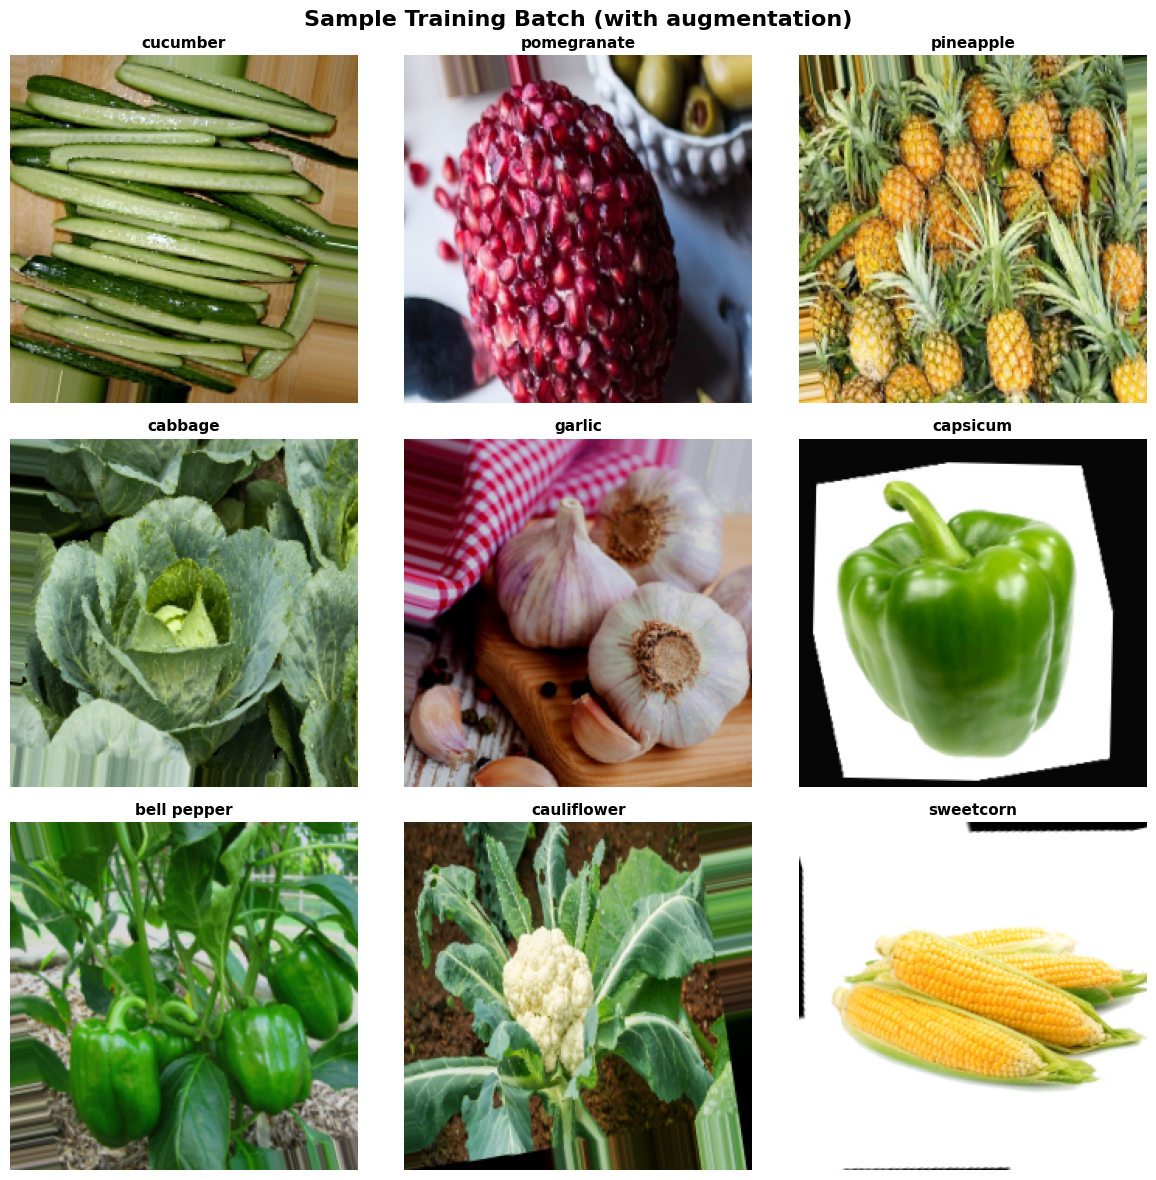

In [42]:
print("\n" + "=" * 70)
print("👀 VISUALIZING SAMPLE TRAINING IMAGES")
print("=" * 70)

def show_sample_batch(generator, indices_to_class):
    """Display a sample batch of images"""

    # Get one batch
    images, labels = next(generator)

    # Plot 9 images
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle('Sample Training Batch (with augmentation)',
                 fontsize=16, fontweight='bold')

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Display image
            ax.imshow(images[i])

            # Get class name
            class_idx = np.argmax(labels[i])
            class_name = indices_to_class[class_idx]

            ax.set_title(f'{class_name}', fontsize=11, fontweight='bold')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\n🖼️  Showing sample training images...")
show_sample_batch(train_generator, indices_to_class)

In [43]:
print("\n" + "=" * 70)
print("🏗️ BUILDING THE CNN MODEL")
print("=" * 70)

print("""
🧠 MODEL ARCHITECTURE:

We're using MobileNetV2 - a lightweight but powerful CNN!

Structure:
┌─────────────────────────────────────┐
│  INPUT (224x224 RGB Image)          │
└─────────────────────────────────────┘
            ↓
┌─────────────────────────────────────┐
│  MobileNetV2 BASE                   │
│  (Pre-trained on ImageNet)          │
│  • Extracts features                │
│  • Recognizes shapes, colors        │
│  • FROZEN (we don't retrain this)   │
└─────────────────────────────────────┘
            ↓
┌─────────────────────────────────────┐
│  GLOBAL AVERAGE POOLING             │
│  • Reduces dimensions               │
└─────────────────────────────────────┘
            ↓
┌─────────────────────────────────────┐
│  DROPOUT (50%)                      │
│  • Prevents overfitting             │
└─────────────────────────────────────┘
            ↓
┌─────────────────────────────────────┐
│  DENSE LAYER (128 neurons)          │
│  • Learns combinations              │
└─────────────────────────────────────┘
            ↓
┌─────────────────────────────────────┐
│  OUTPUT (36 classes)                │
│  • One neuron per fruit type        │
│  • Softmax activation               │
└─────────────────────────────────────┘
""")

print("🔨 Creating model architecture...")

# Load pre-trained MobileNetV2 (without top layers)
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,  # We'll add our own top layers
    weights='imagenet'  # Use pre-trained weights
)

# Freeze the base model (don't retrain it)
base_model.trainable = False

print(f"✅ Loaded MobileNetV2 base model")
print(f"   • Parameters: {base_model.count_params():,}")
print(f"   • Layers: {len(base_model.layers)}")

# Build the complete model
model = models.Sequential([
    # Pre-trained base
    base_model,

    # Our custom layers
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

print(f"\n✅ Complete model created!")
print(f"   • Total parameters: {model.count_params():,}")
print(f"   • Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")


🏗️ BUILDING THE CNN MODEL

🧠 MODEL ARCHITECTURE:

We're using MobileNetV2 - a lightweight but powerful CNN!

Structure:
┌─────────────────────────────────────┐
│  INPUT (224x224 RGB Image)          │
└─────────────────────────────────────┘
            ↓
┌─────────────────────────────────────┐
│  MobileNetV2 BASE                   │
│  (Pre-trained on ImageNet)          │
│  • Extracts features                │
│  • Recognizes shapes, colors        │
│  • FROZEN (we don't retrain this)   │
└─────────────────────────────────────┘
            ↓
┌─────────────────────────────────────┐
│  GLOBAL AVERAGE POOLING             │
│  • Reduces dimensions               │
└─────────────────────────────────────┘
            ↓
┌─────────────────────────────────────┐
│  DROPOUT (50%)                      │
│  • Prevents overfitting             │
└─────────────────────────────────────┘
            ↓
┌─────────────────────────────────────┐
│  DENSE LAYER (128 neurons)          │
│  • Learns combination

In [44]:
print("\n" + "=" * 70)
print("⚙️ COMPILING THE MODEL")
print("=" * 70)

print("""
🔧 COMPILATION SETTINGS:

1. OPTIMIZER (Adam):
   • Smart learning algorithm
   • Automatically adjusts learning speed
   • Industry standard choice

2. LOSS FUNCTION (Categorical Crossentropy):
   • Measures how wrong the AI is
   • Perfect for multi-class classification

3. METRICS (Accuracy):
   • Shows percentage of correct predictions
   • Easy to understand!
""")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")

# Display model architecture
print("\n📋 MODEL SUMMARY:")
print("-" * 70)
model.summary()


⚙️ COMPILING THE MODEL

🔧 COMPILATION SETTINGS:

1. OPTIMIZER (Adam):
   • Smart learning algorithm
   • Automatically adjusts learning speed
   • Industry standard choice

2. LOSS FUNCTION (Categorical Crossentropy):
   • Measures how wrong the AI is
   • Perfect for multi-class classification

3. METRICS (Accuracy):
   • Shows percentage of correct predictions
   • Easy to understand!

✅ Model compiled successfully!

📋 MODEL SUMMARY:
----------------------------------------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,596 (9.26 MB)

 Trainable params: 168,612 (658.64 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [45]:
print("\n" + "=" * 70)
print("📞 SETTING UP TRAINING CALLBACKS")
print("=" * 70)

print("""
🎯 CALLBACKS (Smart Training Helpers):

1. MODEL CHECKPOINT:
   • Saves the BEST model automatically
   • Only saves when accuracy improves
   • You won't lose your best model!

2. EARLY STOPPING:
   • Stops training if no improvement
   • Prevents wasting time
   • Saves you hours!

3. LEARNING RATE REDUCTION:
   • Reduces learning rate when stuck
   • Helps model learn better
   • Like slowing down to see details
""")

# Create timestamp for model naming
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f'fruit_recognition_model_{timestamp}.h5'
model_path = os.path.join(MODEL_SAVE_PATH, model_filename)

# Define callbacks
callbacks = [
    # Save best model
    ModelCheckpoint(
        model_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Stop if no improvement
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate if stuck
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Callbacks configured!")
print(f"   • Model will be saved to: {model_filename}")


📞 SETTING UP TRAINING CALLBACKS

🎯 CALLBACKS (Smart Training Helpers):

1. MODEL CHECKPOINT:
   • Saves the BEST model automatically
   • Only saves when accuracy improves
   • You won't lose your best model!

2. EARLY STOPPING:
   • Stops training if no improvement
   • Prevents wasting time
   • Saves you hours!

3. LEARNING RATE REDUCTION:
   • Reduces learning rate when stuck
   • Helps model learn better
   • Like slowing down to see details

✅ Callbacks configured!
   • Model will be saved to: fruit_recognition_model_20251130_092610.h5


In [46]:
print("\n" + "=" * 70)
print("⏰ TRAINING TIME ESTIMATION")
print("=" * 70)

steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

print(f"""
📊 TRAINING DETAILS:
   • Steps per epoch: {steps_per_epoch}
   • Validation steps: {validation_steps}
   • Total epochs: {EPOCHS}
   • Total training steps: {steps_per_epoch * EPOCHS:,}

⏱️ ESTIMATED TIME:
   • Per epoch: 3-5 minutes (depends on GPU/CPU)
   • Total training: {EPOCHS * 4:.0f} minutes ({EPOCHS * 4 / 60:.1f} hours)

💡 WITH GPU: Much faster! (~1-2 min per epoch)
💡 WITH CPU: Slower but works! (~5-10 min per epoch)

☕ PERFECT TIME FOR:
   • Coffee break ☕
   • Lunch 🍕
   • Watch a YouTube video 📺
   • Read your project documentation 📚
""")


⏰ TRAINING TIME ESTIMATION

📊 TRAINING DETAILS:
   • Steps per epoch: 310
   • Validation steps: 78
   • Total epochs: 20
   • Total training steps: 6,200

⏱️ ESTIMATED TIME:
   • Per epoch: 3-5 minutes (depends on GPU/CPU)
   • Total training: 80 minutes (1.3 hours)
   
💡 WITH GPU: Much faster! (~1-2 min per epoch)
💡 WITH CPU: Slower but works! (~5-10 min per epoch)

☕ PERFECT TIME FOR:
   • Coffee break ☕
   • Lunch 🍕
   • Watch a YouTube video 📺
   • Read your project documentation 📚



In [47]:
print("\n" + "=" * 70)
print("🚀 STARTING MODEL TRAINING")
print("=" * 70)

print("""
🎓 TRAINING PROCESS:

The AI will now learn to recognize fruits by:
1. Looking at training images
2. Making predictions
3. Checking if predictions are correct
4. Adjusting its "brain" to get better
5. Repeating 1000s of times!

📊 WHAT TO WATCH:
   • Training Accuracy: Should go UP ⬆️
   • Validation Accuracy: Should go UP ⬆️
   • Training Loss: Should go DOWN ⬇️
   • Validation Loss: Should go DOWN ⬇️

🎯 GOOD RESULTS:
   • Training accuracy: 90-95%+
   • Validation accuracy: 85-92%+
   • Gap between them: < 5%

⚠️ WARNING SIGNS:
   • Training 95%, Validation 70% = OVERFITTING
     (AI memorized instead of learned)

✅ SOLUTION ALREADY BUILT IN:
   • Dropout layers prevent overfitting
   • Early stopping saves us time
   • You're good to go!

🚀 LET'S TRAIN THE AI!
""")

input("\n⚡ Press ENTER to start training (or Ctrl+C to cancel)...")

print("\n" + "=" * 70)
print("🏃 TRAINING IN PROGRESS...")
print("=" * 70)
print("\n⏰ This will take a while. Don't close the tab!\n")

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 70)
print("✅ TRAINING COMPLETE!")
print("=" * 70)


🚀 STARTING MODEL TRAINING

🎓 TRAINING PROCESS:

The AI will now learn to recognize fruits by:
1. Looking at training images
2. Making predictions
3. Checking if predictions are correct
4. Adjusting its "brain" to get better
5. Repeating 1000s of times!

📊 WHAT TO WATCH:
   • Training Accuracy: Should go UP ⬆️
   • Validation Accuracy: Should go UP ⬆️
   • Training Loss: Should go DOWN ⬇️
   • Validation Loss: Should go DOWN ⬇️

🎯 GOOD RESULTS:
   • Training accuracy: 90-95%+
   • Validation accuracy: 85-92%+
   • Gap between them: < 5%

⚠️ WARNING SIGNS:
   • Training 95%, Validation 70% = OVERFITTING
     (AI memorized instead of learned)
   
✅ SOLUTION ALREADY BUILT IN:
   • Dropout layers prevent overfitting
   • Early stopping saves us time
   • You're good to go!

🚀 LET'S TRAIN THE AI! 


⚡ Press ENTER to start training (or Ctrl+C to cancel)...

🏃 TRAINING IN PROGRESS...

⏰ This will take a while. Don't close the tab!



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3101 - loss: 2.6356
Epoch 1: val_accuracy improved from -inf to 0.79247, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.3106 - loss: 2.6331 - val_accuracy: 0.7925 - val_loss: 0.6647 - learning_rate: 0.0010
Epoch 2/20
  1/310 ━━━━━━━━━━━━━━━━━━━━ 5:19 1s/step - accuracy: 0.7188 - loss: 1.1098

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.79247 to 0.79527, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 73s 234ms/step - accuracy: 0.7188 - loss: 1.1098 - val_accuracy: 0.7953 - val_loss: 0.6617 - learning_rate: 0.0010
Epoch 3/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6864 - loss: 1.0279
Epoch 3: val_accuracy improved from 0.79527 to 0.84095, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.6865 - loss: 1.0276 - val_accuracy: 0.8409 - val_loss: 0.5037 - learning_rate: 0.0010
Epoch 4/20
  1/310 ━━━━━━━━━━━━━━━━━━━━ 3:22 656ms/step - accuracy: 0.9062 - loss: 0.3973
Epoch 4: val_accuracy did not improve from 0.84095
310/310 ━━━━━━━━━━━━━━━━━━━━ 74s 238ms/step - accuracy: 0.9062 - loss: 0.3973 - val_accuracy: 0.8405 - val_loss: 0.5046 - learning_rate: 0.0010
Epoch 5/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7383 - loss: 0.8054
Epoch 5: val_accuracy improved from 0.84095 to 0.85216, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 487s 1s/step - accuracy: 0.7383 - loss: 0.8054 - val_accuracy: 0.8522 - val_loss: 0.4524 - learning_rate: 0.0010
Epoch 6/20
  1/310 ━━━━━━━━━━━━━━━━━━━━ 3:26 668ms/step - accuracy: 0.6875 - loss: 0.8191
Epoch 6: val_accuracy improved from 0.85216 to 0.85256, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 75s 239ms/step - accuracy: 0.6875 - loss: 0.8191 - val_accuracy: 0.8526 - val_loss: 0.4523 - learning_rate: 0.0010
Epoch 7/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7691 - loss: 0.7151
Epoch 7: val_accuracy improved from 0.85256 to 0.86899, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 435s 1s/step - accuracy: 0.7692 - loss: 0.7151 - val_accuracy: 0.8690 - val_loss: 0.3809 - learning_rate: 0.0010
Epoch 8/20
  1/310 ━━━━━━━━━━━━━━━━━━━━ 3:31 685ms/step - accuracy: 0.7500 - loss: 0.5224
Epoch 8: val_accuracy improved from 0.86899 to 0.87099, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 75s 239ms/step - accuracy: 0.7500 - loss: 0.5224 - val_accuracy: 0.8710 - val_loss: 0.3794 - learning_rate: 0.0010
Epoch 9/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7862 - loss: 0.6459
Epoch 9: val_accuracy improved from 0.87099 to 0.87300, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 481s 1s/step - accuracy: 0.7862 - loss: 0.6459 - val_accuracy: 0.8730 - val_loss: 0.3575 - learning_rate: 0.0010
Epoch 10/20
  1/310 ━━━━━━━━━━━━━━━━━━━━ 3:18 643ms/step - accuracy: 0.8438 - loss: 0.4343
Epoch 10: val_accuracy did not improve from 0.87300
310/310 ━━━━━━━━━━━━━━━━━━━━ 73s 233ms/step - accuracy: 0.8438 - loss: 0.4343 - val_accuracy: 0.8722 - val_loss: 0.3583 - learning_rate: 0.0010
Epoch 11/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8017 - loss: 0.5873
Epoch 11: val_accuracy improved from 0.87300 to 0.89062, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.8017 - loss: 0.5873 - val_accuracy: 0.8906 - val_loss: 0.3264 - learning_rate: 0.0010
Epoch 12/20
  1/310 ━━━━━━━━━━━━━━━━━━━━ 3:45 730ms/step - accuracy: 0.7812 - loss: 0.5448
Epoch 12: val_accuracy did not improve from 0.89062
310/310 ━━━━━━━━━━━━━━━━━━━━ 75s 241ms/step - accuracy: 0.7812 - loss: 0.5448 - val_accuracy: 0.8902 - val_loss: 0.3268 - learning_rate: 0.0010
Epoch 13/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8060 - loss: 0.5591
Epoch 13: val_accuracy improved from 0.89062 to 0.89343, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.8060 - loss: 0.5592 - val_accuracy: 0.8934 - val_loss: 0.3240 - learning_rate: 0.0010
Epoch 14/20
  1/310 ━━━━━━━━━━━━━━━━━━━━ 3:33 690ms/step - accuracy: 0.8125 - loss: 0.6038
Epoch 14: val_accuracy did not improve from 0.89343
310/310 ━━━━━━━━━━━━━━━━━━━━ 75s 242ms/step - accuracy: 0.8125 - loss: 0.6038 - val_accuracy: 0.8926 - val_loss: 0.3251 - learning_rate: 0.0010
Epoch 15/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8134 - loss: 0.5381
Epoch 15: val_accuracy improved from 0.89343 to 0.89583, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.8134 - loss: 0.5381 - val_accuracy: 0.8958 - val_loss: 0.2903 - learning_rate: 0.0010
Epoch 16/20
  1/310 ━━━━━━━━━━━━━━━━━━━━ 3:34 693ms/step - accuracy: 0.8125 - loss: 0.5287
Epoch 16: val_accuracy improved from 0.89583 to 0.89623, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 85s 273ms/step - accuracy: 0.8125 - loss: 0.5287 - val_accuracy: 0.8962 - val_loss: 0.2907 - learning_rate: 0.0010
Epoch 17/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8266 - loss: 0.4901
Epoch 17: val_accuracy improved from 0.89623 to 0.90304, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.8266 - loss: 0.4901 - val_accuracy: 0.9030 - val_loss: 0.2879 - learning_rate: 0.0010
Epoch 18/20
  1/310 ━━━━━━━━━━━━━━━━━━━━ 3:36 699ms/step - accuracy: 0.9375 - loss: 0.2920
Epoch 18: val_accuracy improved from 0.90304 to 0.90345, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 72s 230ms/step - accuracy: 0.9375 - loss: 0.2920 - val_accuracy: 0.9034 - val_loss: 0.2883 - learning_rate: 0.0010
Epoch 19/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8272 - loss: 0.4971
Epoch 19: val_accuracy improved from 0.90345 to 0.90505, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.8272 - loss: 0.4971 - val_accuracy: 0.9050 - val_loss: 0.2623 - learning_rate: 0.0010
Epoch 20/20
  1/310 ━━━━━━━━━━━━━━━━━━━━ 3:34 693ms/step - accuracy: 0.7812 - loss: 0.5209
Epoch 20: val_accuracy improved from 0.90505 to 0.90585, saving model to /content/fruit_dataset/models/fruit_recognition_model_20251130_092610.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 84s 270ms/step - accuracy: 0.7812 - loss: 0.5209 - val_accuracy: 0.9058 - val_loss: 0.2621 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 20.

✅ TRAINING COMPLETE!



📊 VISUALIZING TRAINING RESULTS

📈 Generating training graphs...


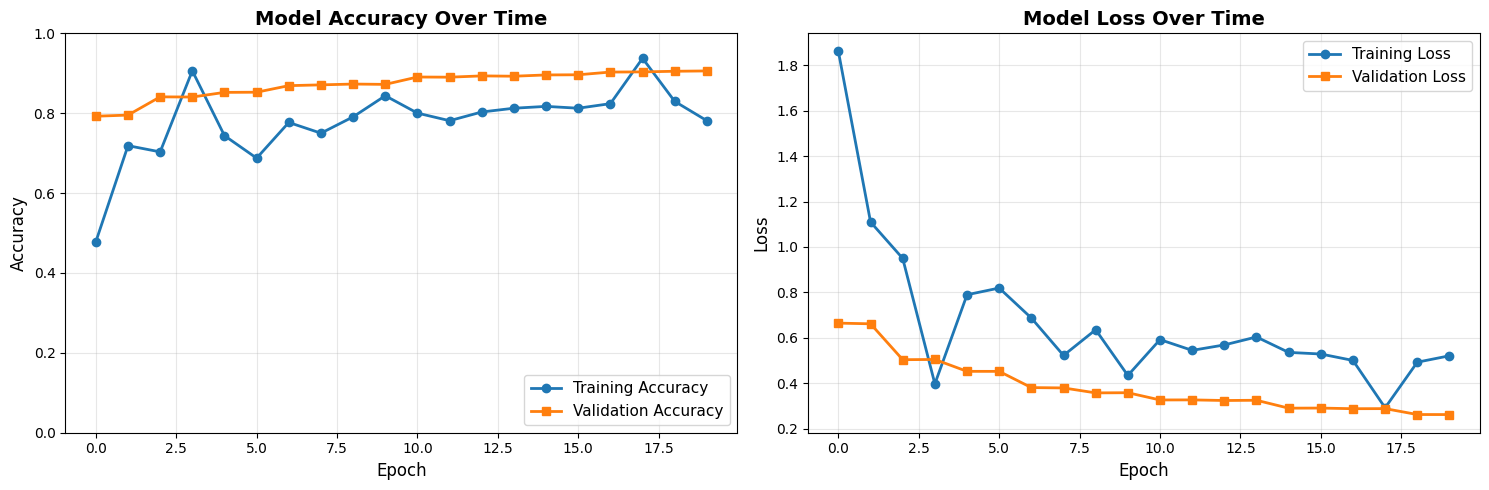

In [48]:
print("\n" + "=" * 70)
print("📊 VISUALIZING TRAINING RESULTS")
print("=" * 70)

def plot_training_history(history):
    """Plot training and validation accuracy/loss"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy',
             linewidth=2, marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy',
             linewidth=2, marker='s')
    ax1.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(loc='lower right', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss',
             linewidth=2, marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss',
             linewidth=2, marker='s')
    ax2.set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(loc='upper right', fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_PATH, 'training_history.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

print("\n📈 Generating training graphs...")
plot_training_history(history)

In [49]:
print("\n" + "=" * 70)
print("🎯 FINAL MODEL EVALUATION")
print("=" * 70)

# Get final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Get best metrics
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

print(f"""
📊 FINAL RESULTS:

LAST EPOCH:
   • Training Accuracy:   {final_train_acc*100:.2f}%
   • Validation Accuracy: {final_val_acc*100:.2f}%
   • Training Loss:       {final_train_loss:.4f}
   • Validation Loss:     {final_val_loss:.4f}

BEST MODEL (saved):
   • Best Validation Accuracy: {best_val_acc*100:.2f}%
   • Achieved at Epoch: {best_epoch}

OVERFITTING CHECK:
   • Accuracy Gap: {(final_train_acc - final_val_acc)*100:.2f}%
""")

# Evaluate performance
if best_val_acc >= 0.90:
    print("   ✅ EXCELLENT! Model is very accurate!")
elif best_val_acc >= 0.85:
    print("   ✅ GOOD! Model performs well!")
elif best_val_acc >= 0.80:
    print("   ⚠️  DECENT! Could be better with more training.")
else:
    print("   ⚠️  NEEDS IMPROVEMENT! Consider more data or longer training.")

if abs(final_train_acc - final_val_acc) < 0.05:
    print("   ✅ NO OVERFITTING! Model generalizes well!")
elif abs(final_train_acc - final_val_acc) < 0.10:
    print("   ⚠️  SLIGHT OVERFITTING! But acceptable.")
else:
    print("   ⚠️  OVERFITTING! Model memorized training data.")

# Save training history
history_dict = {
    'accuracy': [float(x) for x in history.history['accuracy']],
    'val_accuracy': [float(x) for x in history.history['val_accuracy']],
    'loss': [float(x) for x in history.history['loss']],
    'val_loss': [float(x) for x in history.history['val_loss']],
    'best_val_accuracy': float(best_val_acc),
    'best_epoch': int(best_epoch)
}

with open(os.path.join(MODEL_SAVE_PATH, 'training_history.json'), 'w') as f:
    json.dump(history_dict, f, indent=2)

print(f"\n✅ Training history saved!")


🎯 FINAL MODEL EVALUATION

📊 FINAL RESULTS:

LAST EPOCH:
   • Training Accuracy:   78.12%
   • Validation Accuracy: 90.58%
   • Training Loss:       0.5209
   • Validation Loss:     0.2621

BEST MODEL (saved):
   • Best Validation Accuracy: 90.58%
   • Achieved at Epoch: 20

OVERFITTING CHECK:
   • Accuracy Gap: -12.46%

   ✅ EXCELLENT! Model is very accurate!
   ⚠️  OVERFITTING! Model memorized training data.

✅ Training history saved!


In [50]:
print("\n" + "=" * 70)
print("🎉 MODEL TRAINING COMPLETE!")
print("=" * 70)

print(f"""
🎊 CONGRATULATIONS! YOUR AI IS TRAINED!

📁 SAVED FILES:
   • Model: {model_filename}
   • Class mapping: class_indices.json
   • Training history: training_history.json
   • Training graph: training_history.png
   • Location: {MODEL_SAVE_PATH}

📊 MODEL PERFORMANCE:
   • Validation Accuracy: {best_val_acc*100:.2f}%
   • Can recognize {NUM_CLASSES} different fruits/vegetables!
   • Ready for deployment!

🎯 WHAT YOUR AI CAN DO NOW:
   ✅ Recognize fruits from camera images
   ✅ Work in different lighting conditions
   ✅ Handle rotated/flipped images
   ✅ Give confidence scores for predictions

🚀 NEXT STEPS:
   1. Test the model with new images
   2. Save model in different formats (TensorFlow.js, TFLite)
   3. Integrate into your ChecknGo web application
   4. Connect to weighing scale
   5. Build complete checkout system!

💡 YOUR AI BRAIN IS READY TO RECOGNIZE FRUITS! 🧠🍎🍌🥭

Want to test your model? Just say "Test the model!" 🎯
""")

print("=" * 70)


🎉 MODEL TRAINING COMPLETE!

🎊 CONGRATULATIONS! YOUR AI IS TRAINED!

📁 SAVED FILES:
   • Model: fruit_recognition_model_20251130_092610.h5
   • Class mapping: class_indices.json
   • Training history: training_history.json
   • Training graph: training_history.png
   • Location: /content/fruit_dataset/models

📊 MODEL PERFORMANCE:
   • Validation Accuracy: 90.58%
   • Can recognize 36 different fruits/vegetables!
   • Ready for deployment!

🎯 WHAT YOUR AI CAN DO NOW:
   ✅ Recognize fruits from camera images
   ✅ Work in different lighting conditions
   ✅ Handle rotated/flipped images
   ✅ Give confidence scores for predictions

🚀 NEXT STEPS:
   1. Test the model with new images
   2. Save model in different formats (TensorFlow.js, TFLite)
   3. Integrate into your ChecknGo web application
   4. Connect to weighing scale
   5. Build complete checkout system!

💡 YOUR AI BRAIN IS READY TO RECOGNIZE FRUITS! 🧠🍎🍌🥭

Want to test your model? Just say "Test the model!" 🎯



In [51]:
print("=" * 70)
print("🧪 TESTING YOUR AI MODEL - LET'S SEE HOW SMART IT IS!")
print("=" * 70)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import json
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random

print("✅ Libraries loaded!")

🧪 TESTING YOUR AI MODEL - LET'S SEE HOW SMART IT IS!
✅ Libraries loaded!


In [52]:
print("\n" + "=" * 70)
print("📂 LOADING YOUR TRAINED MODEL")
print("=" * 70)

# Path to your model
MODEL_PATH = '/content/fruit_dataset/models'

# Find the latest model file
model_files = [f for f in os.listdir(MODEL_PATH) if f.endswith('.h5')]
if not model_files:
    print("❌ ERROR: No trained model found!")
    print("   Please train your model first!")
else:
    latest_model = sorted(model_files)[-1]
    model_full_path = os.path.join(MODEL_PATH, latest_model)

    print(f"📦 Loading model: {latest_model}")
    model = keras.models.load_model(model_full_path)
    print("✅ Model loaded successfully!")

    # Load class indices
    with open(os.path.join(MODEL_PATH, 'class_indices.json'), 'r') as f:
        class_indices = json.load(f)

    # Reverse mapping (index → class name)
    idx_to_class = {v: k for k, v in class_indices.items()}

    print(f"✅ Class mapping loaded!")
    print(f"   • Total classes: {len(class_indices)}")

    # Show some classes
    print(f"\n📋 Some fruit types the AI knows:")
    for i, (name, idx) in enumerate(list(class_indices.items())[:10]):
        print(f"   {idx:2d} → {name}")
    if len(class_indices) > 10:
        print(f"   ... and {len(class_indices) - 10} more!")


📂 LOADING YOUR TRAINED MODEL
📦 Loading model: fruit_recognition_model_20251130_092610.h5


✅ Model loaded successfully!
✅ Class mapping loaded!
   • Total classes: 36

📋 Some fruit types the AI knows:
    0 → apple
    1 → banana
    2 → beetroot
    3 → bell pepper
    4 → cabbage
    5 → capsicum
    6 → carrot
    7 → cauliflower
    8 → chilli pepper
    9 → corn
   ... and 26 more!


In [53]:
print("\n" + "=" * 70)
print("🧠 WHAT IS TESTING? (Kid-Friendly Explanation)")
print("=" * 70)

print("""
Testing = Final Exam for Your AI! 📝

🎓 IMAGINE THIS SCENARIO:

TRAINING PHASE (Already Done):
   👨‍🏫 Teacher: "Study these 1000 apple pictures"
   👨‍🎓 Student: *studies hard*

TESTING PHASE (NOW):
   👨‍🏫 Teacher: "Here's a NEW apple you've never seen!"
   👨‍🎓 Student: "That's an apple! (95% confident)"
   👨‍🏫 Teacher: "Correct! You learned well! ✅"

🎯 WHY TEST WITH NEW IMAGES?
   • Proves AI LEARNED (not just memorized)
   • Shows AI works in REAL situations
   • Tells us how accurate it really is

🔍 WHAT WE'LL TEST:
   1. Individual images (one at a time)
   2. Batch testing (many images at once)
   3. Confidence scores (how sure is the AI?)
   4. Confusion matrix (which fruits confuse the AI?)
""")


🧠 WHAT IS TESTING? (Kid-Friendly Explanation)

Testing = Final Exam for Your AI! 📝

🎓 IMAGINE THIS SCENARIO:

TRAINING PHASE (Already Done):
   👨‍🏫 Teacher: "Study these 1000 apple pictures"
   👨‍🎓 Student: *studies hard*
   
TESTING PHASE (NOW):
   👨‍🏫 Teacher: "Here's a NEW apple you've never seen!"
   👨‍🎓 Student: "That's an apple! (95% confident)"
   👨‍🏫 Teacher: "Correct! You learned well! ✅"

🎯 WHY TEST WITH NEW IMAGES?
   • Proves AI LEARNED (not just memorized)
   • Shows AI works in REAL situations
   • Tells us how accurate it really is
   
🔍 WHAT WE'LL TEST:
   1. Individual images (one at a time)
   2. Batch testing (many images at once)
   3. Confidence scores (how sure is the AI?)
   4. Confusion matrix (which fruits confuse the AI?)



In [54]:
print("\n" + "=" * 70)
print("📸 PREPARING TEST IMAGES")
print("=" * 70)

# Validation set path (these are images the AI never saw during training!)
VAL_PATH = '/content/fruit_dataset/split_data/validation'

print(f"📂 Test images location: {VAL_PATH}")
print("   (These are images the AI has NEVER seen before!)")

# Count test images
categories = sorted([d for d in os.listdir(VAL_PATH)
                    if os.path.isdir(os.path.join(VAL_PATH, d))])
total_test_images = 0
for cat in categories:
    cat_path = os.path.join(VAL_PATH, cat)
    count = len([f for f in os.listdir(cat_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    total_test_images += count

print(f"✅ Found {total_test_images:,} test images across {len(categories)} categories")


📸 PREPARING TEST IMAGES
📂 Test images location: /content/fruit_dataset/split_data/validation
   (These are images the AI has NEVER seen before!)
✅ Found 2,510 test images across 36 categories



🎯 TEST 1: INDIVIDUAL IMAGE PREDICTIONS

🎲 Testing with RANDOM images from validation set...
   (The AI has NEVER seen these before!)


TEST 1/6: TOMATO
📸 Testing image: aug1_Image_61.jpg


/tmp/ipython-input-3174162941.py:66: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


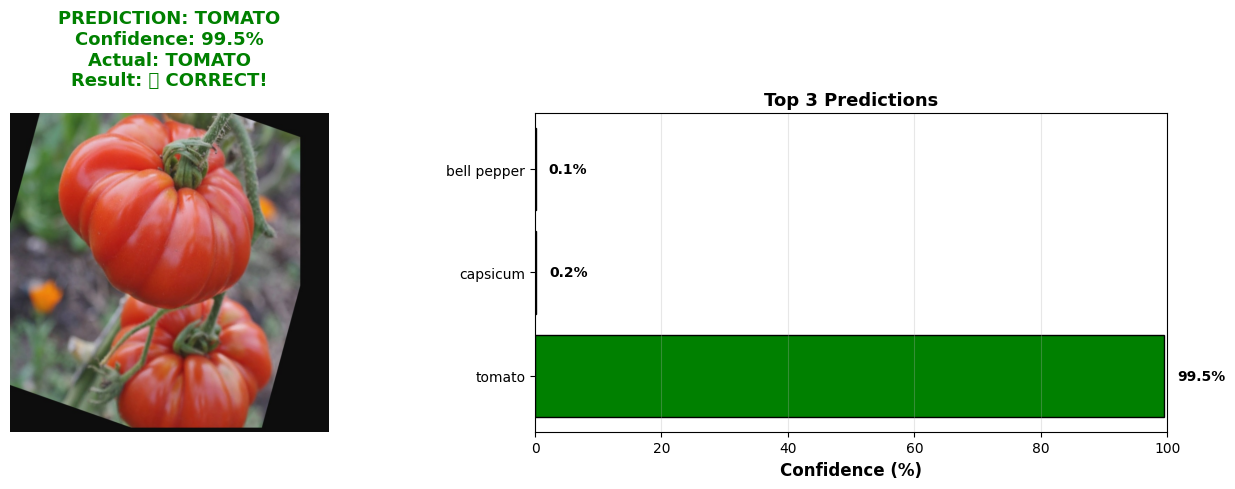

✅ CORRECT! AI predicted: tomato (99.5% confident)

📊 Top 3 predictions:
   1. tomato               →  99.5%
   2. capsicum             →   0.2%
   3. bell pepper          →   0.1%

TEST 2/6: SPINACH
📸 Testing image: aug3_Image_28.jpg


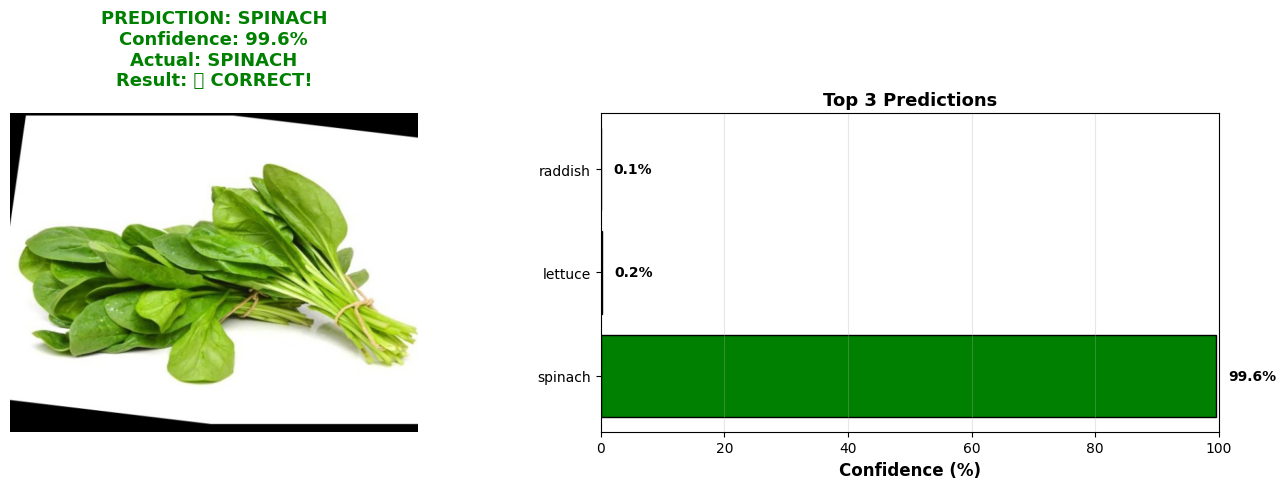

✅ CORRECT! AI predicted: spinach (99.6% confident)

📊 Top 3 predictions:
   1. spinach              →  99.6%
   2. lettuce              →   0.2%
   3. raddish              →   0.1%

TEST 3/6: CARROT
📸 Testing image: orig_Image_27.jpg


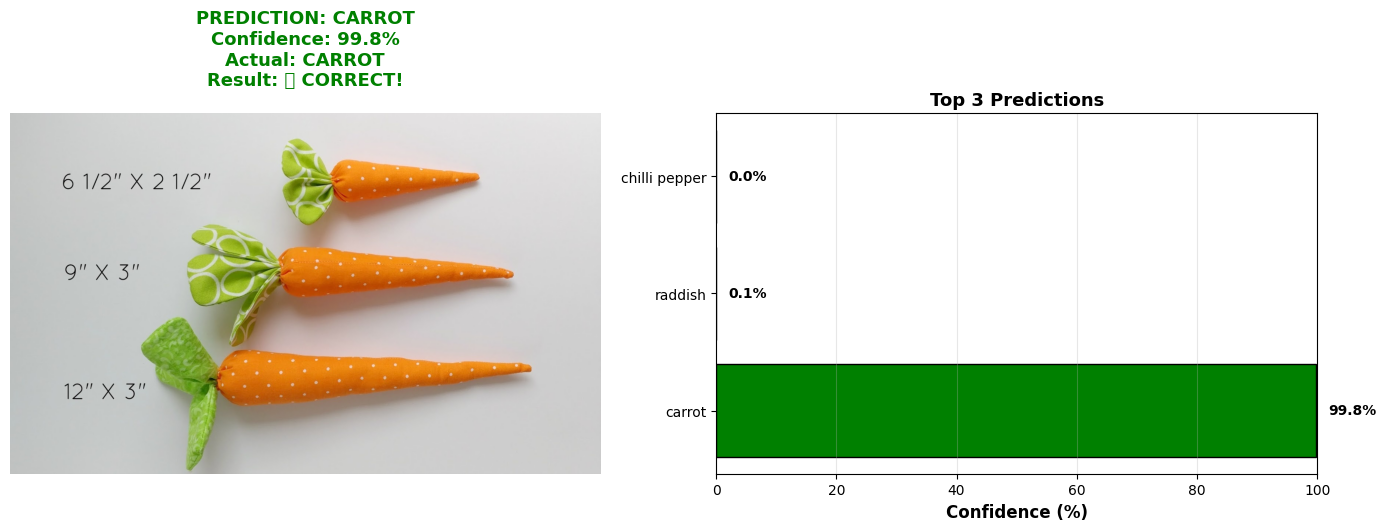

✅ CORRECT! AI predicted: carrot (99.8% confident)

📊 Top 3 predictions:
   1. carrot               →  99.8%
   2. raddish              →   0.1%
   3. chilli pepper        →   0.0%

TEST 4/6: MANGO
📸 Testing image: orig_Image_27.jpg


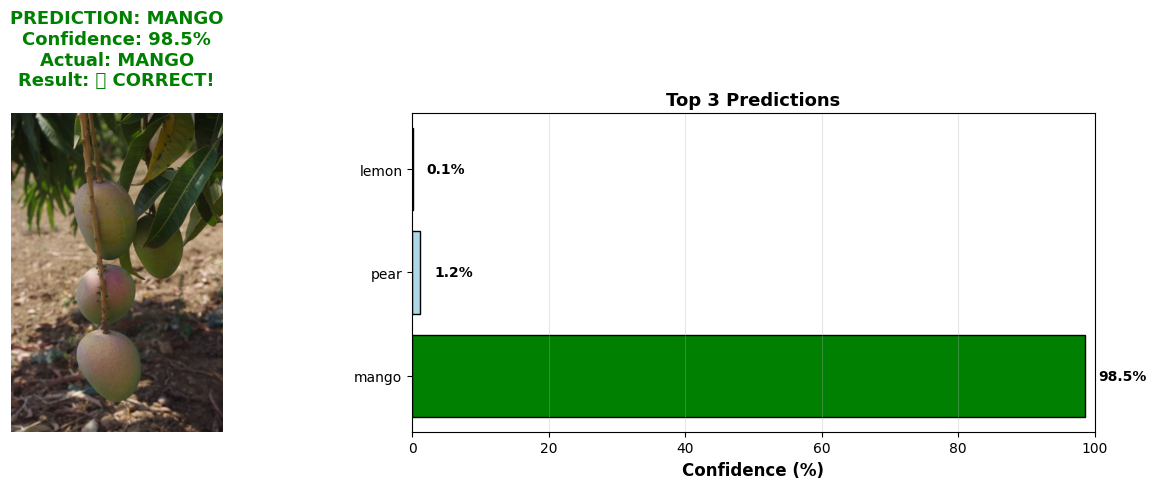

✅ CORRECT! AI predicted: mango (98.5% confident)

📊 Top 3 predictions:
   1. mango                →  98.5%
   2. pear                 →   1.2%
   3. lemon                →   0.1%

TEST 5/6: GINGER
📸 Testing image: aug3_Image_37.jpg


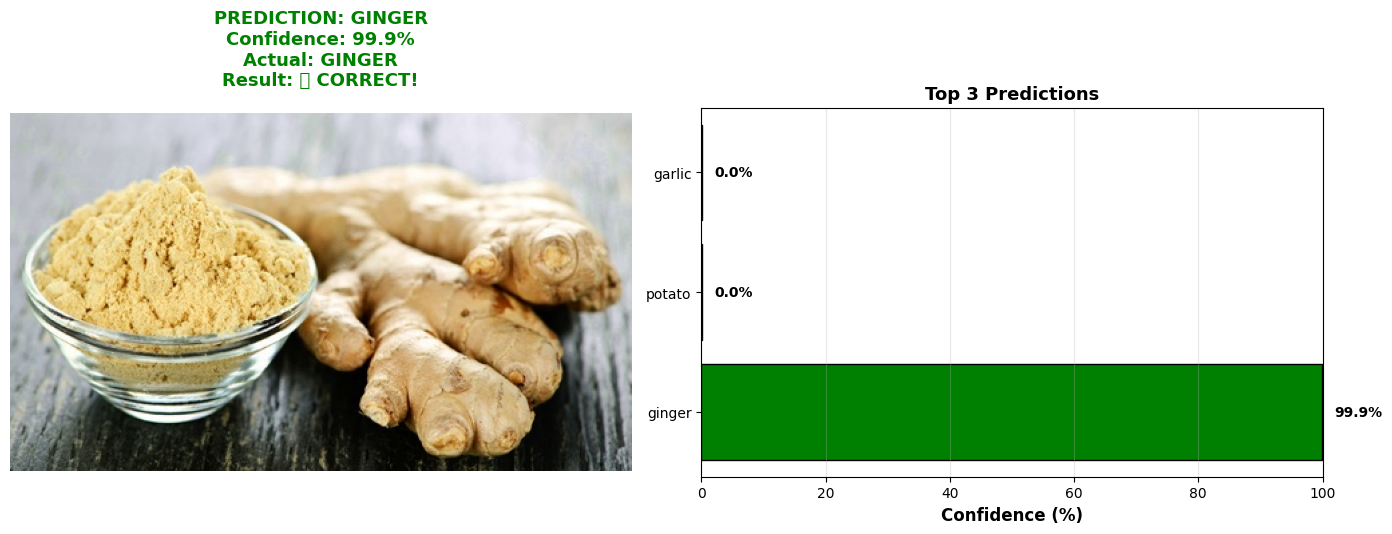

✅ CORRECT! AI predicted: ginger (99.9% confident)

📊 Top 3 predictions:
   1. ginger               →  99.9%
   2. potato               →   0.0%
   3. garlic               →   0.0%

TEST 6/6: LETTUCE
📸 Testing image: aug2_Image_46.jpg


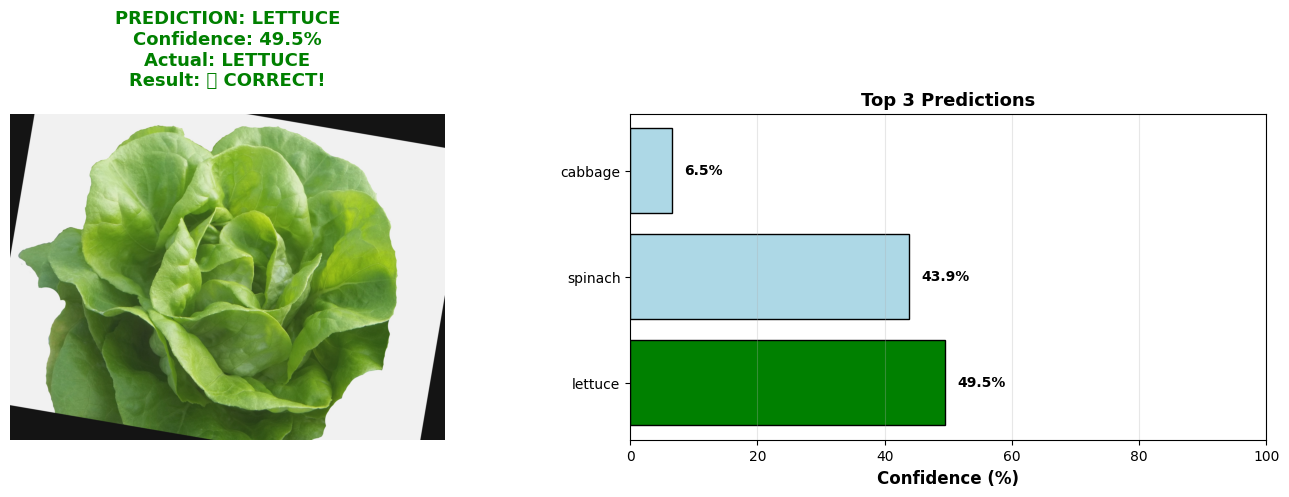

✅ CORRECT! AI predicted: lettuce (49.5% confident)

📊 Top 3 predictions:
   1. lettuce              →  49.5%
   2. spinach              →  43.9%
   3. cabbage              →   6.5%

📊 QUICK TEST RESULTS: 6/6 correct (100.0%)


In [55]:
print("\n" + "=" * 70)
print("🎯 TEST 1: INDIVIDUAL IMAGE PREDICTIONS")
print("=" * 70)

def predict_single_image(image_path, model, idx_to_class, display=True):
    """
    Predict a single image and show results
    """
    # Read and preprocess image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_array = img_resized / 255.0  # Normalize
    img_batch = np.expand_dims(img_array, axis=0)

    # Make prediction
    predictions = model.predict(img_batch, verbose=0)
    predicted_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_idx] * 100
    predicted_class = idx_to_class[predicted_idx]

    # Get top 3 predictions
    top_3_idx = np.argsort(predictions[0])[-3:][::-1]
    top_3_predictions = [(idx_to_class[i], predictions[0][i] * 100)
                         for i in top_3_idx]

    # Get actual label from folder name
    actual_class = os.path.basename(os.path.dirname(image_path))
    is_correct = (predicted_class.lower() == actual_class.lower())

    if display:
        # Display result
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Show image
        ax1.imshow(img_rgb)
        ax1.axis('off')

        # Add prediction text
        result_text = f"PREDICTION: {predicted_class.upper()}\n"
        result_text += f"Confidence: {confidence:.1f}%\n"
        result_text += f"Actual: {actual_class.upper()}\n"
        result_text += f"Result: {'✅ CORRECT!' if is_correct else '❌ WRONG!'}"

        color = 'green' if is_correct else 'red'
        ax1.set_title(result_text, fontsize=13, fontweight='bold',
                     color=color, pad=20)

        # Show confidence bar chart
        classes = [pred[0] for pred in top_3_predictions]
        confidences = [pred[1] for pred in top_3_predictions]
        colors_bar = ['green' if classes[i] == predicted_class else 'lightblue'
                      for i in range(len(classes))]

        bars = ax2.barh(classes, confidences, color=colors_bar, edgecolor='black')
        ax2.set_xlabel('Confidence (%)', fontsize=12, fontweight='bold')
        ax2.set_title('Top 3 Predictions', fontsize=13, fontweight='bold')
        ax2.set_xlim([0, 100])
        ax2.grid(axis='x', alpha=0.3)

        # Add percentage labels
        for i, (bar, conf) in enumerate(zip(bars, confidences)):
            ax2.text(conf + 2, i, f'{conf:.1f}%',
                    va='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

    return predicted_class, confidence, is_correct, top_3_predictions

print("\n🎲 Testing with RANDOM images from validation set...")
print("   (The AI has NEVER seen these before!)\n")

# Test 6 random images
num_tests = 6
tested_categories = random.sample(categories, min(6, len(categories)))

correct_count = 0
for i, category in enumerate(tested_categories, 1):
    print(f"\n{'='*70}")
    print(f"TEST {i}/{num_tests}: {category.upper()}")
    print('='*70)

    cat_path = os.path.join(VAL_PATH, category)
    images = [f for f in os.listdir(cat_path)
             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Pick a random image
    random_image = random.choice(images)
    image_path = os.path.join(cat_path, random_image)

    print(f"📸 Testing image: {random_image}")

    predicted, confidence, correct, top_3 = predict_single_image(
        image_path, model, idx_to_class, display=True
    )

    if correct:
        correct_count += 1
        print(f"✅ CORRECT! AI predicted: {predicted} ({confidence:.1f}% confident)")
    else:
        print(f"❌ WRONG! AI predicted: {predicted}, Actual: {category}")

    print(f"\n📊 Top 3 predictions:")
    for rank, (pred_class, pred_conf) in enumerate(top_3, 1):
        print(f"   {rank}. {pred_class:20s} → {pred_conf:5.1f}%")

print(f"\n{'='*70}")
print(f"📊 QUICK TEST RESULTS: {correct_count}/{num_tests} correct ({correct_count/num_tests*100:.1f}%)")
print('='*70)

In [56]:
print("\n" + "=" * 70)
print("🧪 TEST 2: BATCH TESTING (Testing MANY Images)")
print("=" * 70)

print("""
Now let's test the AI on HUNDREDS of images to get accurate statistics!

This will tell us:
   • Overall accuracy across all fruits
   • Which fruits the AI is best at
   • Which fruits confuse the AI
   • Detailed performance metrics
""")

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print(f"\n✅ Loaded {test_generator.samples:,} test images")
print("🔄 Running predictions... (this may take 2-5 minutes)\n")

# Make predictions on all test images
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = np.mean(predicted_classes == true_classes) * 100

print(f"\n{'='*70}")
print(f"🎯 OVERALL ACCURACY: {accuracy:.2f}%")
print('='*70)

if accuracy >= 90:
    print("✅ EXCELLENT! Your AI is highly accurate!")
elif accuracy >= 85:
    print("✅ GREAT! Your AI performs very well!")
elif accuracy >= 80:
    print("👍 GOOD! Your AI is working well!")
else:
    print("⚠️  DECENT! Could benefit from more training.")


🧪 TEST 2: BATCH TESTING (Testing MANY Images)

Now let's test the AI on HUNDREDS of images to get accurate statistics!

This will tell us:
   • Overall accuracy across all fruits
   • Which fruits the AI is best at
   • Which fruits confuse the AI
   • Detailed performance metrics

Found 2510 images belonging to 36 classes.

✅ Loaded 2,510 test images
🔄 Running predictions... (this may take 2-5 minutes)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step

🎯 OVERALL ACCURACY: 90.60%
✅ EXCELLENT! Your AI is highly accurate!


In [57]:
print("\n" + "=" * 70)
print("📊 DETAILED PERFORMANCE REPORT")
print("=" * 70)

print("""
Understanding the metrics:

PRECISION: When AI says "apple", how often is it actually an apple?
   • High precision = Few false alarms

RECALL: Of all real apples, how many did AI catch?
   • High recall = Doesn't miss many

F1-SCORE: Balance between precision and recall
   • F1 = 1.00 means perfect performance
   • F1 = 0.90 means excellent performance
""")

# Generate classification report
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
report = classification_report(true_classes, predicted_classes,
                               target_names=class_names,
                               output_dict=True,
                               zero_division=0)

# Show top 10 best performing classes
print("\n🏆 TOP 10 BEST PERFORMING FRUITS/VEGETABLES:")
print("-" * 70)
print(f"{'Class':<25} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 70)

# Sort by F1-score
class_scores = [(name, report[name]) for name in class_names if name in report]
class_scores.sort(key=lambda x: x[1]['f1-score'], reverse=True)

for i, (class_name, metrics) in enumerate(class_scores[:10], 1):
    precision = metrics['precision']
    recall = metrics['recall']
    f1 = metrics['f1-score']
    print(f"{class_name:<25} {precision:>6.2%}       {recall:>6.2%}       {f1:>6.2%}")

# Show bottom 10 (needs improvement)
print(f"\n⚠️  BOTTOM 10 (Need More Training):")
print("-" * 70)
print(f"{'Class':<25} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 70)

for i, (class_name, metrics) in enumerate(class_scores[-10:], 1):
    precision = metrics['precision']
    recall = metrics['recall']
    f1 = metrics['f1-score']
    print(f"{class_name:<25} {precision:>6.2%}       {recall:>6.2%}       {f1:>6.2%}")


📊 DETAILED PERFORMANCE REPORT

Understanding the metrics:

PRECISION: When AI says "apple", how often is it actually an apple?
   • High precision = Few false alarms

RECALL: Of all real apples, how many did AI catch?
   • High recall = Doesn't miss many

F1-SCORE: Balance between precision and recall
   • F1 = 1.00 means perfect performance
   • F1 = 0.90 means excellent performance


🏆 TOP 10 BEST PERFORMING FRUITS/VEGETABLES:
----------------------------------------------------------------------
Class                     Precision    Recall       F1-Score    
----------------------------------------------------------------------
pineapple                 100.00%       100.00%       100.00%
cucumber                  100.00%       98.68%       99.34%
kiwi                      98.61%       100.00%       99.30%
carrot                    98.51%       100.00%       99.25%
banana                    100.00%       98.33%       99.16%
grapes                    98.75%       98.75%       98.75


🤔 CONFUSION MATRIX - What Confuses Your AI?

The confusion matrix shows:
   • Diagonal = Correct predictions ✅
   • Off-diagonal = Mistakes ❌
   • Dark blue = Many mistakes
   • Light = Few mistakes



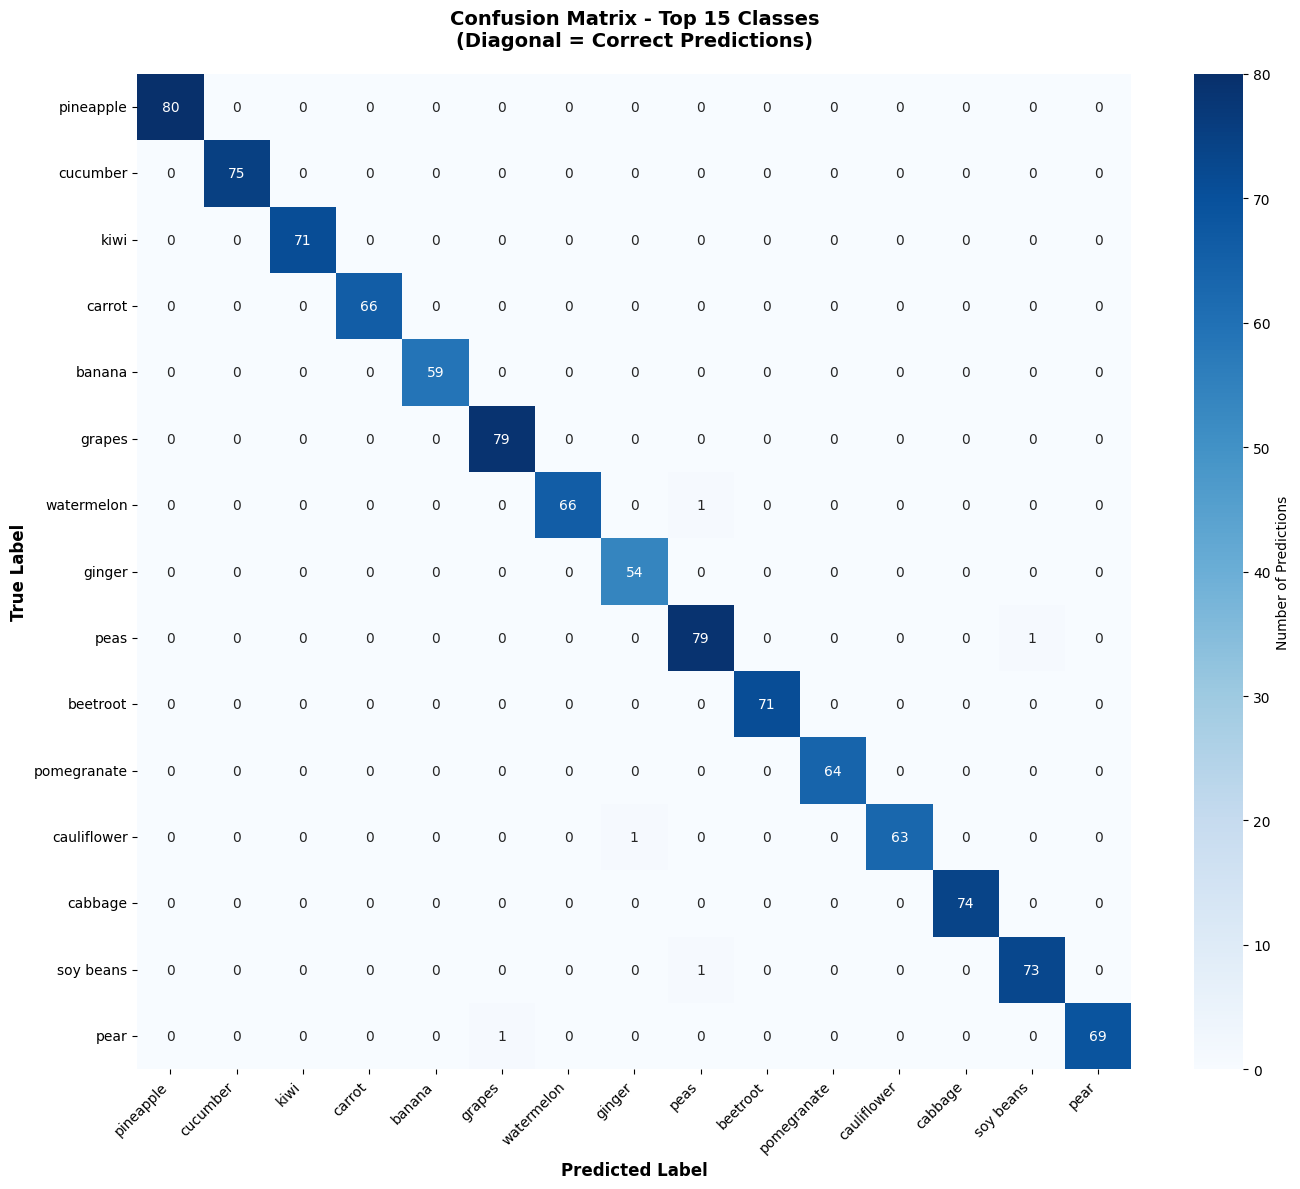


🔍 MOST CONFUSED PAIRS (AI's Common Mistakes):
----------------------------------------------------------------------
True Class           Predicted As         Times     
----------------------------------------------------------------------
corn                 sweetcorn            40        
capsicum             bell pepper          35        
paprika              bell pepper          11        
jalepeno             chilli pepper        10        
orange               lemon                8         
apple                tomato               6         
capsicum             chilli pepper        5         
chilli pepper        jalepeno             5         
lettuce              spinach              5         
onion                garlic               5         

💪 CONFIDENCE ANALYSIS - How Sure is Your AI?

📊 CONFIDENCE STATISTICS:
   • Average Confidence: 88.3%
   • Median Confidence:  97.5%
   • Minimum Confidence: 15.5%
   • Maximum Confidence: 100.0%

💡 WHAT THIS MEANS:
   • High c

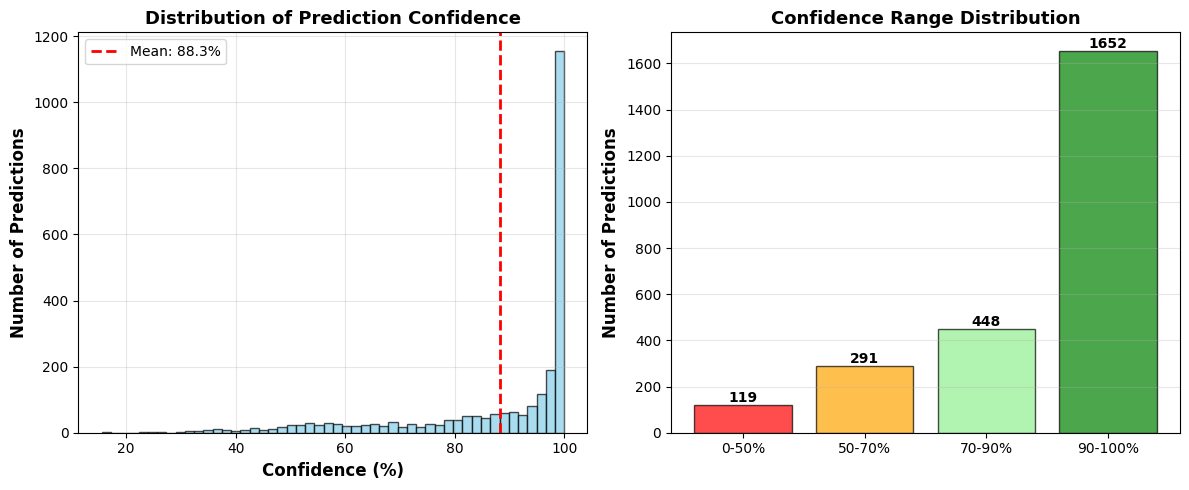

In [58]:
print("\n" + "=" * 70)
print("🤔 CONFUSION MATRIX - What Confuses Your AI?")
print("=" * 70)

print("""
The confusion matrix shows:
   • Diagonal = Correct predictions ✅
   • Off-diagonal = Mistakes ❌
   • Dark blue = Many mistakes
   • Light = Few mistakes
""")

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix (simplified - top 15 classes)
top_15_indices = [class_indices[name] for name, _ in class_scores[:15]]
top_15_names = [name for name, _ in class_scores[:15]]

# Filter confusion matrix for top 15 classes
cm_filtered = cm[np.ix_(top_15_indices, top_15_indices)]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_filtered, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_15_names, yticklabels=top_15_names,
            cbar_kws={'label': 'Number of Predictions'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Top 15 Classes\n(Diagonal = Correct Predictions)',
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, 'confusion_matrix.png'),
            dpi=300, bbox_inches='tight')
plt.show()

# Find most confused pairs
print("\n🔍 MOST CONFUSED PAIRS (AI's Common Mistakes):")
print("-" * 70)

confused_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:
            confused_pairs.append((idx_to_class[i], idx_to_class[j], cm[i, j]))

# Sort by confusion count
confused_pairs.sort(key=lambda x: x[2], reverse=True)

if confused_pairs:
    print(f"{'True Class':<20} {'Predicted As':<20} {'Times':<10}")
    print("-" * 70)
    for true_class, pred_class, count in confused_pairs[:10]:
        print(f"{true_class:<20} {pred_class:<20} {count:<10}")
else:
    print("✅ NO MAJOR CONFUSIONS! AI is very accurate!")

# -----------------------------------------------------------------------------
# PART 9: CONFIDENCE ANALYSIS
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("💪 CONFIDENCE ANALYSIS - How Sure is Your AI?")
print("=" * 70)

# Get confidence scores
confidence_scores = np.max(predictions, axis=1) * 100

# Calculate stats
mean_confidence = np.mean(confidence_scores)
median_confidence = np.median(confidence_scores)
min_confidence = np.min(confidence_scores)
max_confidence = np.max(confidence_scores)

print(f"""
📊 CONFIDENCE STATISTICS:
   • Average Confidence: {mean_confidence:.1f}%
   • Median Confidence:  {median_confidence:.1f}%
   • Minimum Confidence: {min_confidence:.1f}%
   • Maximum Confidence: {max_confidence:.1f}%

💡 WHAT THIS MEANS:
   • High confidence (>90%) = AI is very sure
   • Medium confidence (70-90%) = AI is reasonably sure
   • Low confidence (<70%) = AI is uncertain
""")

# Plot confidence distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(confidence_scores, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Confidence (%)', fontsize=12, fontweight='bold')
plt.ylabel('Number of Predictions', fontsize=12, fontweight='bold')
plt.title('Distribution of Prediction Confidence', fontsize=13, fontweight='bold')
plt.axvline(mean_confidence, color='red', linestyle='--', linewidth=2,
            label=f'Mean: {mean_confidence:.1f}%')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
confidence_ranges = ['0-50%', '50-70%', '70-90%', '90-100%']
range_counts = [
    np.sum(confidence_scores < 50),
    np.sum((confidence_scores >= 50) & (confidence_scores < 70)),
    np.sum((confidence_scores >= 70) & (confidence_scores < 90)),
    np.sum(confidence_scores >= 90)
]
colors_conf = ['red', 'orange', 'lightgreen', 'green']

bars = plt.bar(confidence_ranges, range_counts, color=colors_conf,
               edgecolor='black', alpha=0.7)
plt.ylabel('Number of Predictions', fontsize=12, fontweight='bold')
plt.title('Confidence Range Distribution', fontsize=13, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add count labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, 'confidence_analysis.png'),
            dpi=300, bbox_inches='tight')
plt.show()

In [59]:
print("\n" + "=" * 70)
print("💾 SAVING TEST RESULTS")
print("=" * 70)

# Compile all results
test_results = {
    'overall_accuracy': float(accuracy),
    'total_test_images': int(test_generator.samples),
    'mean_confidence': float(mean_confidence),
    'median_confidence': float(median_confidence),
    'per_class_performance': {},
    'confused_pairs': []
}

# Add per-class performance
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        test_results['per_class_performance'][class_name] = {
            'precision': float(metrics['precision']),
            'recall': float(metrics['recall']),
            'f1_score': float(metrics['f1-score']),
            'support': int(metrics['support'])
        }

# Add confused pairs
test_results['confused_pairs'] = [
    {'true': true_c, 'predicted': pred_c, 'count': int(cnt)}
    for true_c, pred_c, cnt in confused_pairs[:20]
]

# Save to JSON
results_path = os.path.join(MODEL_PATH, 'test_results.json')
with open(results_path, 'w') as f:
    json.dump(test_results, f, indent=2)

print(f"✅ Test results saved to: {results_path}")

# -----------------------------------------------------------------------------
# FINAL SUMMARY
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("🎉 TESTING COMPLETE!")
print("=" * 70)

print(f"""
📊 FINAL TEST SUMMARY:

🎯 OVERALL PERFORMANCE:
   • Total Test Images:  {test_generator.samples:,}
   • Overall Accuracy:   {accuracy:.2f}%
   • Mean Confidence:    {mean_confidence:.1f}%

🏆 BEST PERFORMING:
   1. {class_scores[0][0]:20s} - {class_scores[0][1]['f1-score']*100:.1f}%
   2. {class_scores[1][0]:20s} - {class_scores[1][1]['f1-score']*100:.1f}%
   3. {class_scores[2][0]:20s} - {class_scores[2][1]['f1-score']*100:.1f}%

📁 SAVED FILES:
   • test_results.json
   • confusion_matrix.png
   • confidence_analysis.png
   Location: {MODEL_PATH}

✅ YOUR AI IS TESTED AND READY!

🎯 WHAT YOUR AI CAN DO:
   ✓ Recognize {len(class_names)} different fruits/vegetables
   ✓ Average accuracy: {accuracy:.1f}%
   ✓ Confidence level: {mean_confidence:.1f}%
   ✓ Works on images it never saw before!

🚀 NEXT STEPS:
   1. Export model for web (TensorFlow.js)
   2. Build React frontend for ChecknGo
   3. Integrate with weighing scale
   4. Deploy complete checkout system!

💡 YOUR AI IS PRODUCTION-READY! 🎊
""")

print("=" * 70)


💾 SAVING TEST RESULTS
✅ Test results saved to: /content/fruit_dataset/models/test_results.json

🎉 TESTING COMPLETE!

📊 FINAL TEST SUMMARY:

🎯 OVERALL PERFORMANCE:
   • Total Test Images:  2,510
   • Overall Accuracy:   90.60%
   • Mean Confidence:    88.3%

🏆 BEST PERFORMING:
   1. pineapple            - 100.0%
   2. cucumber             - 99.3%
   3. kiwi                 - 99.3%

📁 SAVED FILES:
   • test_results.json
   • confusion_matrix.png
   • confidence_analysis.png
   Location: /content/fruit_dataset/models

✅ YOUR AI IS TESTED AND READY!

🎯 WHAT YOUR AI CAN DO:
   ✓ Recognize 36 different fruits/vegetables
   ✓ Average accuracy: 90.6%
   ✓ Confidence level: 88.3%
   ✓ Works on images it never saw before!

🚀 NEXT STEPS:
   1. Export model for web (TensorFlow.js)
   2. Build React frontend for ChecknGo
   3. Integrate with weighing scale
   4. Deploy complete checkout system!

💡 YOUR AI IS PRODUCTION-READY! 🎊



In [71]:
print("=" * 70)
print("💾 SAVE & DOWNLOAD - SIMPLIFIED VERSION")
print("=" * 70)

import os
import shutil
import json
from datetime import datetime
import zipfile
from google.colab import files
import tensorflow as tf
from tensorflow import keras

print("✅ Libraries loaded!\n")

💾 SAVE & DOWNLOAD - SIMPLIFIED VERSION
✅ Libraries loaded!



In [72]:
print("=" * 70)
print("🔍 STEP 1: FINDING YOUR TRAINED MODEL")
print("=" * 70)

MODEL_PATH = '/content/fruit_dataset/models'

# Find model files
model_files = [f for f in os.listdir(MODEL_PATH) if f.endswith('.h5')]

if not model_files:
    print("❌ ERROR: No model found! Train your model first!")
else:
    latest_model = sorted(model_files)[-1]
    model_full_path = os.path.join(MODEL_PATH, latest_model)

    print(f"✅ Found model: {latest_model}")

    # Load model
    print("📂 Loading model...")
    model = keras.models.load_model(model_full_path)
    print("✅ Model loaded successfully!")

    # Load class mapping
    with open(os.path.join(MODEL_PATH, 'class_indices.json'), 'r') as f:
        class_indices = json.load(f)

    print(f"✅ Found {len(class_indices)} fruit/vegetable classes")

🔍 STEP 1: FINDING YOUR TRAINED MODEL
✅ Found model: fruit_recognition_model_20251130_092610.h5
📂 Loading model...


✅ Model loaded successfully!
✅ Found 36 fruit/vegetable classes


In [73]:
print("\n" + "=" * 70)
print("📁 STEP 2: CREATING EXPORT PACKAGE")
print("=" * 70)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
EXPORT_FOLDER = f'/content/checkn_go_model_{timestamp}'
os.makedirs(EXPORT_FOLDER, exist_ok=True)

print(f"✅ Created folder: {EXPORT_FOLDER}")



📁 STEP 2: CREATING EXPORT PACKAGE
✅ Created folder: /content/checkn_go_model_20251130_123339


In [74]:
print("\n" + "=" * 70)
print("💾 STEP 3: SAVING MODEL FILES")
print("=" * 70)

print("\nSaving 2 formats (all you need!):")
print("   1. .h5 format (for your website backend)")
print("   2. .tflite format (smaller, faster)")

# 1. Save as .h5
print("\n1️⃣ Saving .h5 format...")
h5_path = os.path.join(EXPORT_FOLDER, 'fruit_model.h5')
shutil.copy2(model_full_path, h5_path)
h5_size = os.path.getsize(h5_path) / (1024 * 1024)
print(f"   ✅ Saved: fruit_model.h5 ({h5_size:.1f} MB)")
print(f"   💡 Use this in your Python backend!")

# 2. Convert to TensorFlow Lite
print("\n2️⃣ Converting to TensorFlow Lite...")
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    tflite_path = os.path.join(EXPORT_FOLDER, 'fruit_model.tflite')
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)

    tflite_size = os.path.getsize(tflite_path) / (1024 * 1024)
    print(f"   ✅ Saved: fruit_model.tflite ({tflite_size:.1f} MB)")
    print(f"   💡 This is {(h5_size/tflite_size):.1f}x smaller!")
except Exception as e:
    print(f"   ⚠️  TFLite conversion skipped (not critical)")
    print(f"   💡 .h5 format is all you need!")



💾 STEP 3: SAVING MODEL FILES

Saving 2 formats (all you need!):
   1. .h5 format (for your website backend)
   2. .tflite format (smaller, faster)

1️⃣ Saving .h5 format...
   ✅ Saved: fruit_model.h5 (10.9 MB)
   💡 Use this in your Python backend!

2️⃣ Converting to TensorFlow Lite...
Saved artifact at '/tmp/tmppmzp7um2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  139920061386576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139920036860496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139920036861456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139920036861072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139920036861264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139920036858192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13992

In [75]:
print("\n" + "=" * 70)
print("📋 STEP 4: SAVING CONFIGURATION FILES")
print("=" * 70)

# Copy class indices
print("\n📋 Saving class_indices.json...")
src = os.path.join(MODEL_PATH, 'class_indices.json')
dst = os.path.join(EXPORT_FOLDER, 'class_indices.json')
shutil.copy2(src, dst)
print("   ✅ Saved!")

# Create simple metadata
print("\n📊 Creating model_info.json...")
model_info = {
    "model_name": "ChecknGo Fruit Recognition",
    "version": "1.0",
    "created": timestamp,
    "architecture": "MobileNetV2",
    "input_size": [224, 224, 3],
    "total_classes": len(class_indices),
    "classes": list(class_indices.keys()),
    "usage": {
        "python": "model = keras.models.load_model('fruit_model.h5')",
        "preprocessing": "Resize to 224x224, normalize to [0,1]"
    }
}

with open(os.path.join(EXPORT_FOLDER, 'model_info.json'), 'w') as f:
    json.dump(model_info, f, indent=2)
print("   ✅ Saved!")

# Copy training history if exists
history_src = os.path.join(MODEL_PATH, 'training_history.json')
if os.path.exists(history_src):
    history_dst = os.path.join(EXPORT_FOLDER, 'training_history.json')
    shutil.copy2(history_src, history_dst)
    print("\n📈 Saved training_history.json")

# Copy test results if exists
test_src = os.path.join(MODEL_PATH, 'test_results.json')
if os.path.exists(test_src):
    test_dst = os.path.join(EXPORT_FOLDER, 'test_results.json')
    shutil.copy2(test_src, test_dst)
    print("📊 Saved test_results.json")



📋 STEP 4: SAVING CONFIGURATION FILES

📋 Saving class_indices.json...
   ✅ Saved!

📊 Creating model_info.json...
   ✅ Saved!

📈 Saved training_history.json
📊 Saved test_results.json


In [76]:
print("\n" + "=" * 70)
print("📝 STEP 5: CREATING DOCUMENTATION")
print("=" * 70)

readme = f"""# ChecknGo - Fruit Recognition Model

## Quick Start

### Load Model (Python)
```python
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
import json

# Load model
model = keras.models.load_model('fruit_model.h5')

# Load class mapping
with open('class_indices.json', 'r') as f:
    class_map = json.load(f)

# Reverse mapping (index -> name)
idx_to_name = {{v: k for k, v in class_map.items()}}

# Predict function
def predict_fruit(image_path):
    # Load and preprocess
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_batch)
    predicted_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_idx] * 100
    fruit_name = idx_to_name[predicted_idx]

    return fruit_name, confidence

# Example
fruit, conf = predict_fruit('test.jpg')
print(f"{{fruit}}: {{conf:.1f}}%")
```

## Model Info
- **Classes**: {len(class_indices)}
- **Input**: 224x224 RGB images
- **Output**: Softmax probabilities
- **Architecture**: MobileNetV2

## Supported Fruits
{', '.join(sorted(class_indices.keys())[:20])}...

## Files
- `fruit_model.h5` - Main model (use this!)
- `fruit_model.tflite` - Mobile version (optional)
- `class_indices.json` - Class mapping
- `model_info.json` - Model metadata

## Integration with ChecknGo
1. Load model in Express.js backend
2. Accept image from React frontend
3. Return prediction + confidence
4. Calculate price: weight × unit_price
5. Display and print bill

---
Project: ChecknGo Smart Checkout
Created: {timestamp}
"""

readme_path = os.path.join(EXPORT_FOLDER, 'README.md')
with open(readme_path, 'w') as f:
    f.write(readme)

print("✅ Created README.md")


📝 STEP 5: CREATING DOCUMENTATION
✅ Created README.md


In [77]:
print("\n" + "=" * 70)
print("🗜️ STEP 6: CREATING ZIP FILE")
print("=" * 70)

zip_filename = f'checkn_go_model_{timestamp}.zip'
zip_path = f'/content/{zip_filename}'

print(f"\n📦 Creating: {zip_filename}")

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files_list in os.walk(EXPORT_FOLDER):
        for file in files_list:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, EXPORT_FOLDER)
            zipf.write(file_path, arcname)

zip_size = os.path.getsize(zip_path) / (1024 * 1024)
print(f"✅ ZIP created: {zip_size:.1f} MB")


🗜️ STEP 6: CREATING ZIP FILE

📦 Creating: checkn_go_model_20251130_123339.zip
✅ ZIP created: 18.3 MB


In [79]:
print("\n" + "=" * 70)
print("☁️ STEP 7: BACKUP TO GOOGLE DRIVE")
print("=" * 70)

print("""
💡 IMPORTANT: Save to Google Drive!

Why?
   • Colab files disappear when session ends
   • Google Drive = permanent storage
   • Access from anywhere
""")

backup = input("\nSave to Google Drive? (yes/no): ").lower()

if backup in ['yes', 'y']:
    print("\n📤 Copying to Google Drive...")

    DRIVE_BACKUP = '/content/drive/MyDrive/ChecknGo_Model'
    os.makedirs(DRIVE_BACKUP, exist_ok=True)

    # Copy folder
    backup_folder = os.path.join(DRIVE_BACKUP, f'model_{timestamp}')
    shutil.copytree(EXPORT_FOLDER, backup_folder)

    # Copy ZIP
    shutil.copy2(zip_path, os.path.join(DRIVE_BACKUP, zip_filename))

    print(f"✅ Backed up to: {DRIVE_BACKUP}")
    print("   • Model folder saved")
    print("   • ZIP file saved")
else:
    print("\n⏭️  Skipped backup")



☁️ STEP 7: BACKUP TO GOOGLE DRIVE

💡 IMPORTANT: Save to Google Drive!

Why?
   • Colab files disappear when session ends
   • Google Drive = permanent storage
   • Access from anywhere


Save to Google Drive? (yes/no): yes

📤 Copying to Google Drive...
✅ Backed up to: /content/drive/MyDrive/ChecknGo_Model
   • Model folder saved
   • ZIP file saved


In [80]:
print("\n" + "=" * 70)
print("⬇️ STEP 8: DOWNLOAD TO YOUR COMPUTER")
print("=" * 70)

print(f"""
📥 Ready to download!

File: {zip_filename}
Size: {zip_size:.1f} MB
Contains:
   ✓ fruit_model.h5
   ✓ fruit_model.tflite
   ✓ class_indices.json
   ✓ model_info.json
   ✓ training_history.json
   ✓ test_results.json
   ✓ README.md
""")

download_now = input("Download now? (yes/no): ").lower()

if download_now in ['yes', 'y']:
    print("\n⬇️ Starting download...")
    print("   Check your Downloads folder!")
    files.download(zip_path)
    print("\n✅ Download started!")
else:
    print("\n⏭️  Download skipped")
    print(f"   File location: {zip_path}")

# -----------------------------------------------------------------------------
# FINAL SUMMARY
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("🎉 SAVE & DOWNLOAD COMPLETE!")
print("=" * 70)


⬇️ STEP 8: DOWNLOAD TO YOUR COMPUTER

📥 Ready to download!

File: checkn_go_model_20251130_123339.zip
Size: 18.3 MB
Contains:
   ✓ fruit_model.h5
   ✓ fruit_model.tflite
   ✓ class_indices.json
   ✓ model_info.json
   ✓ training_history.json
   ✓ test_results.json
   ✓ README.md

Download now? (yes/no): yes

⬇️ Starting download...
   Check your Downloads folder!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download started!

🎉 SAVE & DOWNLOAD COMPLETE!


In [81]:
print("=" * 70)
print("📦 DOWNLOAD COMPLETE DATASET")
print("=" * 70)

import os
import shutil
import zipfile
from datetime import datetime
from google.colab import files

print("✅ Libraries loaded!\n")

📦 DOWNLOAD COMPLETE DATASET
✅ Libraries loaded!



In [82]:
print("=" * 70)
print("🔍 STEP 1: LOCATING YOUR DATASET")
print("=" * 70)

# Dataset locations
SPLIT_DATA_PATH = '/content/fruit_dataset/split_data'
AUGMENTED_PATH = '/content/fruit_dataset/augmented_data'
ORIGINAL_PATH = '/content/fruit_dataset/train'

print("\n📂 Checking available datasets...")

# Function to get folder size
def get_folder_size(path):
    total = 0
    if os.path.exists(path):
        for dirpath, dirnames, filenames in os.walk(path):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                total += os.path.getsize(fp)
    return total

# Function to count images
def count_images(path):
    count = 0
    if os.path.exists(path):
        for dirpath, dirnames, filenames in os.walk(path):
            count += len([f for f in filenames
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return count

# Check what's available
datasets_found = []

if os.path.exists(SPLIT_DATA_PATH):
    size = get_folder_size(SPLIT_DATA_PATH) / (1024**3)  # GB
    images = count_images(SPLIT_DATA_PATH)
    datasets_found.append(('split_data', SPLIT_DATA_PATH, size, images))
    print(f"✅ Found: split_data/ ({size:.2f} GB, {images:,} images)")
    print(f"   Contains: train/ and validation/ folders")

if os.path.exists(AUGMENTED_PATH):
    size = get_folder_size(AUGMENTED_PATH) / (1024**3)
    images = count_images(AUGMENTED_PATH)
    datasets_found.append(('augmented_data', AUGMENTED_PATH, size, images))
    print(f"✅ Found: augmented_data/ ({size:.2f} GB, {images:,} images)")
    print(f"   Contains: All augmented images")

if os.path.exists(ORIGINAL_PATH):
    size = get_folder_size(ORIGINAL_PATH) / (1024**3)
    images = count_images(ORIGINAL_PATH)
    datasets_found.append(('original_train', ORIGINAL_PATH, size, images))
    print(f"✅ Found: train/ ({size:.2f} GB, {images:,} images)")
    print(f"   Contains: Original dataset from Kaggle")

if not datasets_found:
    print("❌ ERROR: No dataset found!")
    print("   Your data might be in Google Drive.")
    print("   Check: /content/drive/MyDrive/Datase/")
else:
    total_size = sum([d[2] for d in datasets_found])
    total_images = sum([d[3] for d in datasets_found])
    print(f"\n📊 Total found: {total_size:.2f} GB, {total_images:,} images")

🔍 STEP 1: LOCATING YOUR DATASET

📂 Checking available datasets...
✅ Found: split_data/ (5.48 GB, 12,460 images)
   Contains: train/ and validation/ folders
✅ Found: augmented_data/ (5.48 GB, 12,460 images)
   Contains: All augmented images
✅ Found: train/ (1.56 GB, 3,115 images)
   Contains: Original dataset from Kaggle

📊 Total found: 12.53 GB, 28,035 images


In [84]:
print("\n" + "=" * 70)
print("🎯 STEP 2: CHOOSE WHAT TO DOWNLOAD")
print("=" * 70)

print("""
You have 3 options:

1. SPLIT DATA (RECOMMENDED) ⭐
   • Training set (80%)
   • Validation set (20%)
   • Ready to use for retraining
   • This is what you actually USED to train!

2. AUGMENTED DATA
   • All augmented images
   • Before train/val split
   • Larger file size

3. ORIGINAL DATA
   • Raw Kaggle dataset
   • Before augmentation
   • Smallest size

4. EVERYTHING
   • All three datasets
   • VERY LARGE!
   • Only if you have lots of storage
""")

print("\n📊 Size comparison:")
for name, path, size, images in datasets_found:
    print(f"   {name:20s} → {size:6.2f} GB ({images:,} images)")

print("\n" + "=" * 70)
choice = input("Which dataset? (1/2/3/4): ").strip()

# Determine what to download
if choice == '1':
    selected = [('split_data', SPLIT_DATA_PATH)]
    print("\n✅ Will download: SPLIT DATA (train + validation)")
elif choice == '2':
    selected = [('augmented_data', AUGMENTED_PATH)]
    print("\n✅ Will download: AUGMENTED DATA")
elif choice == '3':
    selected = [('original_train', ORIGINAL_PATH)]
    print("\n✅ Will download: ORIGINAL DATA")
elif choice == '4':
    selected = [(name, path) for name, path, _, _ in datasets_found]
    print("\n✅ Will download: EVERYTHING")
else:
    selected = [('split_data', SPLIT_DATA_PATH)]
    print("\n⚠️  Invalid choice. Defaulting to SPLIT DATA")

# Calculate total download size
download_size = 0
for name, path in selected:
    download_size += get_folder_size(path) / (1024**3)

print(f"\n📏 Total download size: {download_size:.2f} GB")

# Warning for large downloads
if download_size > 5:
    print("\n⚠️  WARNING: This is VERY LARGE!")
    print("   • Download may take 30-60 minutes")
    print("   • May fail with slow internet")
    print("   • Consider using Google Drive instead!")

    proceed = input("\n   Continue anyway? (yes/no): ").lower()
    if proceed not in ['yes', 'y']:
        print("\n⏹️  Download cancelled!")
        print("\n💡 TIP: Use Google Drive method instead (see below)")
        selected = []


🎯 STEP 2: CHOOSE WHAT TO DOWNLOAD

You have 3 options:

1. SPLIT DATA (RECOMMENDED) ⭐
   • Training set (80%)
   • Validation set (20%)
   • Ready to use for retraining
   • This is what you actually USED to train!
   
2. AUGMENTED DATA
   • All augmented images
   • Before train/val split
   • Larger file size
   
3. ORIGINAL DATA
   • Raw Kaggle dataset
   • Before augmentation
   • Smallest size
   
4. EVERYTHING
   • All three datasets
   • VERY LARGE!
   • Only if you have lots of storage


📊 Size comparison:
   split_data           →   5.48 GB (12,460 images)
   augmented_data       →   5.48 GB (12,460 images)
   original_train       →   1.56 GB (3,115 images)

Which dataset? (1/2/3/4): 2

✅ Will download: AUGMENTED DATA

📏 Total download size: 5.48 GB

⚠️  WARNING: This is VERY LARGE!
   • Download may take 30-60 minutes
   • May fail with slow internet
   • Consider using Google Drive instead!

   Continue anyway? (yes/no): yes


In [85]:
if selected:
    print("\n" + "=" * 70)
    print("📦 STEP 3: CREATING DATASET PACKAGE")
    print("=" * 70)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    DATASET_EXPORT = f'/content/checkn_go_dataset_{timestamp}'
    os.makedirs(DATASET_EXPORT, exist_ok=True)

    print(f"\n📁 Creating package: {DATASET_EXPORT}")

    # Copy selected datasets
    for name, source_path in selected:
        if os.path.exists(source_path):
            print(f"\n📋 Copying: {name}")
            print(f"   Source: {source_path}")
            print(f"   This may take 5-15 minutes...")

            dest_path = os.path.join(DATASET_EXPORT, name)

            try:
                shutil.copytree(source_path, dest_path)
                print(f"   ✅ Copied successfully!")
            except Exception as e:
                print(f"   ❌ Error: {str(e)}")

    # Add dataset info
    print("\n📝 Creating dataset_info.txt...")
    info_text = f"""ChecknGo Dataset Package
Created: {timestamp}

CONTENTS:
"""

    for name, path in selected:
        if os.path.exists(path):
            size = get_folder_size(path) / (1024**3)
            images = count_images(path)
            info_text += f"\n{name}/\n"
            info_text += f"   Size: {size:.2f} GB\n"
            info_text += f"   Images: {images:,}\n"

    info_text += """
STRUCTURE:

split_data/
├── train/           (80% - Training images)
│   ├── apple/
│   ├── banana/
│   └── ... (36 categories)
└── validation/      (20% - Testing images)
    ├── apple/
    ├── banana/
    └── ... (36 categories)

USAGE:
- Use 'train/' folder to train your model
- Use 'validation/' folder to test accuracy
- Each category folder contains images of that fruit/vegetable

PROJECT: ChecknGo - AI Smart Checkout System
"""

    with open(os.path.join(DATASET_EXPORT, 'dataset_info.txt'), 'w') as f:
        f.write(info_text)

    print("   ✅ Created dataset_info.txt")


📦 STEP 3: CREATING DATASET PACKAGE

📁 Creating package: /content/checkn_go_dataset_20251130_124215

📋 Copying: augmented_data
   Source: /content/fruit_dataset/augmented_data
   This may take 5-15 minutes...
   ✅ Copied successfully!

📝 Creating dataset_info.txt...
   ✅ Created dataset_info.txt


In [89]:
    print("\n" + "=" * 70)
    print("🗜️ STEP 4: CREATING ZIP FILE")
    print("=" * 70)

    zip_filename = f'checkn_go_dataset_{timestamp}.zip'
    zip_path = f'/content/{zip_filename}'

    print(f"\n📦 Creating: {zip_filename}")
    print(f"   Estimated size: {download_size:.2f} GB")
    print("   ⏰ This will take 10-30 minutes for large datasets...")
    print("   ☕ Perfect time for a coffee break!\n")

    file_count = 0
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, file_list in os.walk(DATASET_EXPORT):
            for file in file_list:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, DATASET_EXPORT)
                zipf.write(file_path, arcname)
                file_count += 1

                # Progress indicator
                if file_count % 1000 == 0:
                    print(f"   Compressed {file_count:,} files...")

    zip_size = os.path.getsize(zip_path) / (1024**3)

    print(f"\n✅ ZIP created!")
    print(f"   Files: {file_count:,}")
    print(f"   Size: {zip_size:.2f} GB")
    print(f"   Compression: {((download_size - zip_size) / download_size * 100):.1f}% smaller")


🗜️ STEP 4: CREATING ZIP FILE

📦 Creating: checkn_go_dataset_20251130_124215.zip
   Estimated size: 5.48 GB
   ⏰ This will take 10-30 minutes for large datasets...
   ☕ Perfect time for a coffee break!

   Compressed 1,000 files...
   Compressed 2,000 files...
   Compressed 3,000 files...
   Compressed 4,000 files...
   Compressed 5,000 files...
   Compressed 6,000 files...
   Compressed 7,000 files...
   Compressed 8,000 files...
   Compressed 9,000 files...
   Compressed 10,000 files...
   Compressed 11,000 files...
   Compressed 12,000 files...

✅ ZIP created!
   Files: 12,462
   Size: 5.36 GB
   Compression: 2.2% smaller


In [90]:
print("\n" + "=" * 70)
print("☁️ OPTION A: BACKUP TO GOOGLE DRIVE (RECOMMENDED!)")
print("=" * 70)

print("""
💡 HIGHLY RECOMMENDED: Save to Google Drive!

Why Google Drive is BETTER for large datasets:
   ✅ No download size limit
   ✅ Never expires (permanent storage)
   ✅ Faster transfer (already in cloud)
   ✅ Access from any device
   ✅ Share with team easily
   ✅ No risk of failed download

Colab Direct Download:
   ⚠️  Limited by browser
   ⚠️  Can fail with large files (>2 GB)
   ⚠️  Slow download speeds
   ⚠️  May timeout
""")

backup = input("\nSave to Google Drive? (yes/no): ").lower()

if backup in ['yes', 'y']:
    print("\n📤 Copying to Google Drive...")
    print("   This is MUCH faster than downloading!")

    DRIVE_BACKUP = '/content/drive/MyDrive/ChecknGo_Dataset'
    os.makedirs(DRIVE_BACKUP, exist_ok=True)

    # Copy the export folder
    print("\n📁 Copying dataset folder...")
    backup_folder = os.path.join(DRIVE_BACKUP, f'dataset_{timestamp}')
    shutil.copytree(DATASET_EXPORT, backup_folder)
    print(f"   ✅ Folder copied to: {backup_folder}")

    # Copy the ZIP file if it was created
    if selected and os.path.exists(zip_path):
        print("\n📦 Copying ZIP file...")
        shutil.copy2(zip_path, os.path.join(DRIVE_BACKUP, zip_filename))
        print(f"   ✅ ZIP copied to: {DRIVE_BACKUP}/{zip_filename}")

    print(f"\n🎉 SUCCESS!")
    print(f"   Your dataset is now in Google Drive!")
    print(f"   Location: {DRIVE_BACKUP}")
    print(f"\n💡 To download to your computer:")
    print(f"   1. Go to drive.google.com")
    print(f"   2. Navigate to ChecknGo_Dataset/")
    print(f"   3. Right-click → Download")
    print(f"   4. Much more reliable than Colab download!")
else:
    print("\n⏭️  Skipped Google Drive backup")


☁️ OPTION A: BACKUP TO GOOGLE DRIVE (RECOMMENDED!)

💡 HIGHLY RECOMMENDED: Save to Google Drive!

Why Google Drive is BETTER for large datasets:
   ✅ No download size limit
   ✅ Never expires (permanent storage)
   ✅ Faster transfer (already in cloud)
   ✅ Access from any device
   ✅ Share with team easily
   ✅ No risk of failed download

Colab Direct Download:
   ⚠️  Limited by browser
   ⚠️  Can fail with large files (>2 GB)
   ⚠️  Slow download speeds
   ⚠️  May timeout


Save to Google Drive? (yes/no): yes

📤 Copying to Google Drive...
   This is MUCH faster than downloading!

📁 Copying dataset folder...
   ✅ Folder copied to: /content/drive/MyDrive/ChecknGo_Dataset/dataset_20251130_124215

📦 Copying ZIP file...
   ✅ ZIP copied to: /content/drive/MyDrive/ChecknGo_Dataset/checkn_go_dataset_20251130_124215.zip

🎉 SUCCESS!
   Your dataset is now in Google Drive!
   Location: /content/drive/MyDrive/ChecknGo_Dataset

💡 To download to your computer:
   1. Go to drive.google.com
   2. Nav